### JOB ANALYZER

Загрузка библиотек

In [1]:
import requests
import regex
import json
import time
from pathlib import Path
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import itertools
from itertools import chain, combinations

import warnings
warnings.simplefilter('ignore')

import re
import nltk

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from tqdm.autonotebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# import gensim.downloader as api
# from gensim.models import WordEmbeddingSimilarityIndex
# from gensim.corpora import Dictionary
# from gensim.models import TfidfModel
# from gensim.models import KeyedVectors
# from gensim.similarities import SparseTermSimilarityMatrix
# from gensim.similarities import SoftCosineSimilarity

from mydata import big_data_ecosystem1, big_data_ecosystem2,data_science, \
                    deep_learning,hadoop_ecosystem,object_detection,programming_languages

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from mapboxgl.utils import *
from mapboxgl.viz import *
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:20,.2f}'.format
np.set_printoptions(precision=4)
In [6]: np.set_printoptions(suppress=True)

Путь к рабочей папке

In [2]:
workpath = Path().absolute()
datapath = str(workpath) + "//data"
if not os.path.exists(datapath):
    os.makedirs(datapath)

In [3]:
datafile = datapath + "//vacancies"
vacnamesfile = datapath + "//vacnames"
employersfile = datapath + "//employers"
data_columns = ['id','premium','billing_type_name','name','response_letter_required','area_name','salary_from','salary_to',
    'salary_currency','salary_gross','type_name','address_lat','address_lng','address_raw','address_metro_station_name',
    'address_metro_line_name','address_metro_lat','address_metro_lng','address_metro_stations','allow_messages',
    'experience_name','schedule_name','employment_name','description','branded_description','key_skills',
    'accept_handicapped','accept_kids','archived','specializations_name','specializations_profarea_name','hidden',
    'quick_responses_allowed','driver_license_types','accept_incomplete_resumes','employer_id','employer_name',
    'employer_url','employer_alternate_url','employer_trusted','published_at','created_at','apply_alternate_url',
    'has_test','alternate_url','accept_temporary','department_name','test_required',
               ]

In [4]:
def getPage(text, search_field, page=0, per_page=100):
    params = {
        "text": f"{text}", # Текст фильтра. В имени должно быть слово "Аналитик"
#         'area': 1, # Поиск ощуществляется по вакансиям города Москва
        "page": page, # Индекс страницы поиска на HH
        "per_page": per_page, # Кол-во вакансий на 1 странице
        "search_field": search_field,
    }
    req = requests.get('https://api.hh.ru/vacancies', params) # Посылаем запрос к API
    data = req.content.decode() # Декодируем его ответ, чтобы Кириллица отображалась корректно
    req.close()
    return data

def flatten_dict(dd, separator ='_', prefix =''): 
    return { prefix + separator + k if prefix else k : v 
             for kk, vv in dd.items() 
             for k, v in flatten_dict(vv, separator, kk).items() 
             } if isinstance(dd, dict) else { prefix : dd } 

def flatten_lol(lol):
    return [s for s in lol for s in s]

def save_data(mydata, file):
    myfile = file + ".pkl"
    if mydata.shape[0] > 0:
        mydata.to_pickle(myfile)
        
def save_list(mylist, file):
    myfile = file + ".pkl"
    if len(mylist) > 0:
        with open(myfile, 'wb') as f:
            pickle.dump(mylist, f)
            
def load_list(file, is_backup=True):
    myfile = file + ".pkl"
    mypath = Path(myfile)
    if mypath.is_file():
        with open(myfile, 'rb') as f:
            mylist = pickle.load(f)
            if is_backup:
                timestr = time.strftime("%Y%m%d-%H%M%S")  
                backup_listfile = file + timestr 
            save_list(mylist, backup_listfile)
    else:
        mylist = None
    return mylist
            
def load_data(file, is_backup=True):
    myfile = file + ".pkl"
    mypath = Path(myfile)
    if mypath.is_file():
        data = pd.read_pickle(myfile)
        if is_backup:
            timestr = time.strftime("%Y%m%d-%H%M%S")  
            backup_datafile = file + timestr 
            save_data(data, backup_datafile)
            
    else:
        data = None
    return data

def change_vac_coltypes(data):
    for column in ['id', 
                   #'test_required'
                  ]:
        data[column] = data[column].astype(int)
    for column in ['premium','response_letter_required','allow_messages','accept_handicapped','accept_kids','archived',
            'hidden','quick_responses_allowed','accept_incomplete_resumes','employer_trusted','has_test','accept_temporary',]:
        data[column] = data[column].astype(bool)
    for column in ['published_at','created_at']:
        data[column] = data[column].astype('datetime64[ns]')
        return data
    
def parse_vac(item):
    myDict = item.copy()
    if type(myDict['key_skills']) is list:
        myDict['key_skills'] = [list(item.values())[0] for item in myDict['key_skills']]
    if type(myDict['specializations']) is list:
        myDict['specializations'] = myDict['specializations'][0]
    myDict = flatten_dict(myDict)
    unusable_keys = [key for key in myDict.keys() if key not in data_columns]
    for key_to_drop in unusable_keys:
        if key_to_drop in myDict.keys():
            del myDict[key_to_drop]
    return myDict    


def get_vac_ids(text, search_field):
    per_page = 100
    jsObj = json.loads(getPage(text=text, search_field=search_field, page=0))
    vacs_total = jsObj['found']
    pages_total = jsObj['pages']
    time.sleep(0.25)
    
    vac_ids = []
    for page in range(pages_total):
        jsObj = json.loads(getPage(text=text, search_field=search_field, per_page=per_page, page=page))
        for i in range(len(jsObj['items'])):
            vac_ids.append(jsObj['items'][i]['id'])
    return vac_ids


def get_vac(vac_name, data, search_field):

    vac_ids = get_vac_ids(vac_name, search_field)

    for vacancy_id, i in zip(vac_ids, range(len(vac_ids))):
        req = requests.get(f'https://api.hh.ru/vacancies/{vacancy_id}')
        parse = req.content.decode()
        req.close()
        jsObj = json.loads(parse)

        myDict = parse_vac(jsObj)   
        if data is None:
            data = pd.DataFrame(columns=data_columns)
        else:
            pass
        id_to_check = int(myDict['id'])
        if id_to_check in list(data['id']):
            data.drop(data.loc[data['id']==id_to_check].index, inplace=True)
        data = data.append(pd.Series(myDict), ignore_index=True)

    data = change_vac_coltypes(data)
    return data

def check_unique_ids(data):
    print(f"Размер данных: {len(data['id'])}")
    print(f"Уникальных ID: {data['id'].nunique()}")
    
def get_vac_sim(raw_data, data, text, search_field):
    
    vac_ids = get_vac_ids(text, search_field)
    
    if raw_data is None:
        raw_data = pd.DataFrame(columns=data_columns)
    else:
        pass
    if len(vac_ids) > 0:
        for vacancy_id, i in zip(vac_ids, range(len(vac_ids))):

            if (int(vacancy_id) not in list(data['id'])) and (int(vacancy_id) not in list(raw_data['id'])):
                
                req = requests.get(f'https://api.hh.ru/vacancies/{vacancy_id}')
                parse = req.content.decode()
                req.close()
                jsObj = json.loads(parse)
                myDict = parse_vac(jsObj)   
                raw_data = raw_data.append(pd.Series(myDict), ignore_index=True)

        raw_data = change_vac_coltypes(raw_data)

    return raw_data


def cyrillic_words_rate(text):
    len_cyr = len(re.findall(r'[А-я]+', text))
    len_total = len(re.findall(r'[А-яA-z]+', text))
    if len_total == 0:
        return 0
    else:
        return len(re.findall(r'[А-я]+', text))/len(re.findall(r'[А-яA-z]+', text))

def get_language(text):
    if cyrillic_words_rate(text) >= 0.2:
        return "cyrillic"
    else:
        return "latin"
    
def preprocess_text(text):
    # Tokenize, clean up input document string
    text = re.sub(r"[Ёё]", "е", text)
    text = re.sub(r"<[^>]*>", "", text)
    text = re.sub(r"(?:&quot)", "", text)
    if cyrillic_words_rate(text) >= 0.2:
        text =  " ".join([stemmer_ru.normal_forms(word)[0] for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 1) and (word not in stopwords)])
    else:
        text =  " ".join([stemmer_en.lemmatize(word) for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 1) and (word not in stopwords)])
    return text

def word_counts(words_list):
    return Counter(words_list)

def get_ngrams(text, n):
    words = [word for word in text.lower().split(' ')]
    return list(ngrams(words, n))

def get_sentences(text):
    tags =["<ul>", "</li>", "</br>", "!", "?"]
    for tag in tags:
        text = text.replace(tag, ".")  
    text = text.split(".")
    return [string for string in [preprocess_text(string) for string in text] if string!=""]

def occurences_counter(column, num=1):
    return Counter(chain.from_iterable(combinations(line, num) for line in column))



def get_matches(data, regex):
    matches = None
    pattern = re.compile(r"%s" % regex)
    matches = re.findall(pattern, data)
    return matches

def get_key_phrases(text):
#         regex = r"<li>(.*?)<\/li>"
#     regex = r"<li[^>]*>((?:(?!<\/li>).)*)<\/li>|(?<=<br)(.*?)(?=<)"
#     regex = r"<li[^>]*>((?:(?!<\/li>).)*)<\/li>|(?<=<br />)(.*?)(?=<)"
    regex = r"<li[^>]*>((?:(?!<\/li>).)*)<\/li>|(?<=<br />)(.*?)(?=<)"
    matches = get_matches(text, regex)
    matches_cleaned = [item for t in matches for item in t if len(item)>0] 
    if len(matches_cleaned) == 0:
        regex = r"(?<=p>)(.*?)(?=<)|(?<=>-)(.*?)(?=<)"
        matches = get_matches(text, regex)
        matches_cleaned = [item for t in matches for item in t if len(item)>0] 
    matches_preprocess = [string for string in [preprocess_text(string) for string in matches_cleaned if len(string)>0] 
                          if len(string)>0]
    return matches_preprocess

def get_tech_stack(text):
    return [t for t in tech_stack if t in text]



def get_emp(emp_id, employers):

    req = requests.get(f'https://api.hh.ru/employers/{emp_id}')
    parse = req.content.decode()
    req.close()
    jsObj = json.loads(parse)
    
    myDict = parse_emp(jsObj)   
    if employers is None:
        employers = pd.DataFrame(columns=data_employer_cols)
    else:
        pass
    if 'id' in myDict.keys():
        id_to_check = int(myDict['id'])
        if id_to_check in list(employers['id']):
            employers.drop(employers.loc[employers['id']==id_to_check].index, inplace=True)
        employers = employers.append(pd.Series(myDict), ignore_index=True)

        employers = change_emp_coltypes(employers)
    return employers

def parse_emp(item):
    myDict = item.copy()
    if 'industries' in myDict.keys():
        if type(myDict['industries']) is list:
            myDict['industries'] = [list(item.values())[1] for item in myDict['industries']]
    myDict = flatten_dict(myDict)
    unusable_keys = [key for key in myDict.keys() if key not in data_employer_cols]
    for key_to_drop in unusable_keys:
        if key_to_drop in myDict.keys():
            del myDict[key_to_drop]
    return myDict  

def change_emp_coltypes(data):
    for column in ['area_id', 'open_vacancies',]:
        data[column] = data[column].astype(int)
    for column in ['trusted',]:
        data[column] = data[column].astype(bool)
        return data
    
    
def get_ngrams_for_key_phrases(text, n):
    strings = [string.lower().split(' ') for string in text]
    strings_to_split = [string for string in strings if len(string) >= n]
    return [tple for tple in [list(ngrams(string, n)) for string in strings_to_split] for tple in tple]

def get_top_ngrams(total_ngram_counts, min_cnt=50):
    tmp = [(k,v) for k, v in total_ngram_counts.most_common() if v >= min_cnt]
    return [k for k, v in tmp]

def get_good_key_phrases(text, top_ngrams):
    return [key for key in text.keys() if key in top_ngrams]


            
def get_words_before(all_sentences, word_rus, word_eng, words_before='1'):
    sentences1 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_rus, string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences2 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_eng, string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences1 |= sentences2
    return sentences1
def get_words_after(all_sentences, word_rus, word_eng, words_after='1'):
    sentences1 = set([sent for sent in [re.findall(word_rus+'(?:\s\w+){'+words_after+'}', string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences2 = set([sent for sent in [re.findall(word_eng+'(?:\s\w+){'+words_after+'}', string) 
                                        for string in all_sentences] for sent in sent if len(sent)>0])
    sentences1 |= sentences2
    return sentences1
def get_words_around(all_sentences, word_rus, word_eng, words_before='1', words_after='1'):
    sentences1 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_rus+'(?:\s\w+){0,'+words_after+'}', 
                                        string) for string in all_sentences] for sent in sent if len(sent)>0])
    sentences2 = set([sent for sent in [re.findall('(?:\w+\s){'+words_before+'}'+word_eng+'(?:\s\w+){0,'+words_after+'}',\
                                        string) for string in all_sentences] for sent in sent if len(sent)>0])
    sentences1 |= sentences2
    return sentences1

def check_frase_in_text(text, search_phrases):
    return any(word in text for word in search_phrases)

def get_words_only(text):
    return re.sub(' +', ' ', re.sub('[^a-zа-я0-9]', ' ', text.lower())).lower()

def currency(num, condition):
    if pd.isnull(num):
        return None
    else:
        divider = {
            'RUR': RUR, 
            'KZT': KZT, 
            'UAH': UAH, 
            'USD': USD, 
            'BYR': BYR, 
            'EUR': EUR,  
            'UZS': UZS,
        }
        return num * divider[condition]

def cond(row, text):
    return any(word in row.lower() for word in text)    
    
def flatten_list_of_lists(text):
#     return [elem for elem in text for elem in elem]
    return " ".join([elem for elem in text for elem in elem])

def list_to_string(text):
#     return [elem for elem in text for elem in elem]
    return " ".join([elem for elem in text])





def draw_barplot(xcol, ycol, data, title, xlabel, ylabel, extra_info=None, TOP=10, rate=25):
    sumdata = data[xcol].sum()
    topdata = data[:TOP]
    plt.figure(figsize=(15,len(topdata)/2))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    g = sns.barplot(y=ycol, x=xcol, data=topdata, orient='h',palette="coolwarm_r", )# palette="RdYlGn_r", )
    labels = [string[:40] for string in topdata[ycol]]
    g.set_yticklabels(labels)

    g.set_title(title)
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)

    for p in g.patches:
        width = p.get_width()   
        g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
    plt.show()

    place = 0
    for index, row in topdata.iterrows():
        place +=1
        if extra_info == None:
            print("{:10} место: {} ({})".format(place, row[ycol], row[xcol]))
        else:
            extra_data = ", ".join([item for item in row[extra_info]])
            print("{:10} место: {} ({}) [{}: {}]".format(place, row[ycol], row[xcol], extra_info, extra_data))
    print("")
    print("Доля лидера {}: общая = {:.2f}%, в топ-рейтинге = {:.2f}%".format(topdata.iloc[0][ycol], 
                                                                             topdata.iloc[0][xcol]/sumdata*100, 
                                                                             topdata.iloc[0][xcol]/topdata[xcol].sum()*100))
    
    first_quartile_byall = [data.iloc[0][ycol]]
    counter = data.iloc[0][xcol]
    threshold = data[xcol].sum() * 0.01 * rate
    for index, row in data[1:].iterrows():
        counter = counter + row[xcol]
        first_quartile_byall.append(row[ycol])
        if counter >= threshold:
            break
 

    print("")
    print("Лидеры, занимающие первые {}% в общем рейтинге: {}".format(rate, first_quartile_byall))    
    
    first_quartile_bytop = [topdata.iloc[0][ycol]]
    counter = topdata.iloc[0][xcol]
    threshold = topdata[xcol].sum() * 0.01 * rate
    for index, row in topdata[1:].iterrows():
        counter = counter + row[xcol]
        first_quartile_bytop.append(row[ycol])
        if counter >= threshold:
            break
          
    print("")
    print("Лидеры, занимающие первые {}% в топ-рейтинге: {}".format(rate, first_quartile_bytop))


In [5]:
data = load_data(datafile)
vac_names = load_list(vacnamesfile)
if len(vac_names) == 0:
    vac_names = ['аналитик данных', 'data analyst']
vac_names_quoted = ['\"'+ item + '\"' for item in vac_names]
with tqdm(total=len(vac_names_quoted)) as pbar:
    for vac_name in vac_names_quoted:
        data = get_vac(vac_name, data, search_field="name")
        pbar.update()
save_data(data, datafile)

In [6]:
data_extended = data.copy()

## PREPROCESS DESC

In [7]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('comtrans')

In [8]:
stemmer_ru = pymorphy2.MorphAnalyzer()
stemmer_en = WordNetLemmatizer()

In [9]:
stopwords = set([word for word in nltk.corpus.stopwords.words('russian') if word != 'не'] \
                + nltk.corpus.stopwords.words('english'))

In [10]:
%%time
data_extended['text_language'] = data_extended['description'].apply(get_language)
data_extended['desc_lemm'] = data_extended.description.apply(preprocess_text)
data_extended['key_phrases'] = data_extended.description.apply(get_key_phrases)

Wall time: 7min 24s


## VACS BY SIMILAR TECH

In [11]:
tech_stack = [big_data_ecosystem1, big_data_ecosystem2,data_science, \
                    deep_learning,hadoop_ecosystem,object_detection,programming_languages]
tech_stack = list(set([l for l in tech_stack for l in l]))
tech_stack = [text.lower() for text in tech_stack]

In [12]:
data_extended['tech_stack'] = data_extended['desc_lemm'].apply(get_tech_stack)

In [13]:
min_stack_len = 5
selected_tech_stack = [l for l in data_extended['tech_stack'].to_list() if len(l) >=min_stack_len]
selected_tech_stack = list(set(tuple(i) for i in selected_tech_stack))
len(selected_tech_stack)

3199

In [14]:
data_potential = None
with tqdm(total=len(selected_tech_stack)) as pbar:
    for tech_stack_set in selected_tech_stack:
        if len(tech_stack_set) > 0:
            search_text = '\"' + '\" AND \"'.join(tech_stack_set) + '\"'
            data_potential = get_vac_sim(data_potential, data, search_text, search_field="description")
        pbar.update()

In [15]:
list(data_potential['name'].unique())

['Java Разработчик',
 'Разработчик Golang/Ведущий разработчик Golang',
 'Разработчик Golang/ Ведущий разработчик Golang',
 'Младший инженер по тестированию/Junior Software Development Engineer in Test (C/C++/Golang)',
 'Recruiter/ Рекрутер в IT-вендор (Regular/ Middle/ Senior)',
 'Developer in QA',
 'Junior Developer in QA',
 'Application Security Engineer',
 'Ведущий инженер-разработчик C/C++ NOS (Network OS)',
 'Старший инженер-программист (Platform)',
 'Аналитик',
 'Algorithm Development Engineer',
 'Senior C++ Engineer',
 'CV Engineer',
 'Senior C++ Developer (разработка систем хранения данных)',
 'Semantic Technologies Engineer (Java)',
 'DevOps инженер (SberRadar)',
 'Системный архитектор',
 'Junior/Middle Python developer (machine learning)',
 'Аналитик CRM',
 'Руководитель по аналитике CVM',
 'Head of Data Analytics',
 'Консультант / Менеджер Технологической Стратегии по направлению "Аналитика и управление данными"',
 'Системный администратор',
 'C/C++ Developer',
 'NPU Compile

In [16]:
vac_names_similar = [
    'аналитик данных',
    'Head of Data Analytics',
    'Business Intelligence Engineer',
    'Data & BI',
    'CV Engineer',
]
            
vac_names_similar_quoted = ['\"'+ item + '\"' for item in vac_names_similar]

In [17]:
data_similar = None
with tqdm(total=len(vac_names_similar_quoted)) as pbar:
    for vac_name in vac_names_similar_quoted:
        data_similar = get_vac_sim(data_similar, data, vac_name, search_field="name")
        pbar.update()

In [18]:
datafile = datapath + "//vacancies"
data_to_save = data.append(data_similar)
check_unique_ids(data_to_save)

Размер данных: 6412
Уникальных ID: 6411


In [19]:
ids_to_drop = data_to_save.groupby('id')['id'].count().rename('cnt').reset_index().sort_values(by='cnt', ascending=False)
clean_data = data_to_save[~data_to_save['id'].isin(list(ids_to_drop[ids_to_drop.cnt > 1]['id']))]

In [20]:
save_data(clean_data, datafile)

vacnamesfile = datapath + "//vacnames"
vacnames_to_save = []
vacnames_to_save.extend(vac_names)
vacnames_to_save.extend(vac_names_similar)
save_list(list(set(vacnames_to_save)), vacnamesfile)

In [21]:
data_extended = clean_data.copy()

In [22]:
check_unique_ids(data_extended)

Размер данных: 6410
Уникальных ID: 6410


## GET EMPLOYERS

In [23]:
employers = load_data(employersfile)

In [24]:
emp_ids = [emp_id for emp_id in data_extended.employer_id.unique() if str(emp_id) != 'nan']

In [25]:
data_employer_cols = ['id', 'trusted', 'name', 'type', 'description', 'site_url', 'alternate_url', 'vacancies_url', 
                      'relations', 'area_id', 'area_name', 'industries', 
                      'open_vacancies']


In [26]:
# employers = None
with tqdm(total=len(emp_ids)) as pbar:
    for emp_id in emp_ids:
        employers = get_emp(emp_id, employers)
        pbar.update()

In [27]:
check_unique_ids(employers)

Размер данных: 1785
Уникальных ID: 1785


In [28]:
employers = employers.rename(columns={'id':'employer_id'})

In [29]:
%%time
data_extended['text_language'] = data_extended['description'].apply(get_language)
data_extended['desc_lemm'] = data_extended.description.apply(preprocess_text)
data_extended['key_phrases'] = data_extended.description.apply(get_key_phrases)
data_extended['tech_stack'] = data_extended['desc_lemm'].apply(get_tech_stack)
data_extended['desc_sentences'] = data_extended['description'].apply(get_sentences)

Wall time: 12min 30s


In [30]:
ngrams_range = 6
min_cnt = 60
with tqdm(total=ngrams_range-1) as pbar:
    for n in range(2,ngrams_range+1):
        data_extended[f'key_phrases_{n}grams'] = data_extended['key_phrases'].apply(get_ngrams_for_key_phrases, n=n)
        data_extended[f'key_phrases_{n}gram_counts'] = data_extended[f'key_phrases_{n}grams'].apply(word_counts)
        globals()[f'total_key_phrases_{n}grams'] = pd.DataFrame(data_extended[f'key_phrases_{n}gram_counts'])\
                                                .sum()\
                                                .to_dict()[f'key_phrases_{n}gram_counts']
        globals()[f'top_key_phrases_{n}grams'] = get_top_ngrams(globals()[f'total_key_phrases_{n}grams'], min_cnt)
        data_extended[f'good_key_phrases_{n}grams'] = data_extended[f'key_phrases_{n}gram_counts']\
                                        .apply(get_good_key_phrases, top_ngrams=globals()[f'top_key_phrases_{n}grams'])
        pbar.update()

## DATA FOR REASERCH

Исследования будут проводиться по активным вакансиям в Москве. Очевидно, что в Москве самое большое количество вакансий в области анализа данных. Тем не менее, посмотрим на настоящие данные по локациям и количеству вакансий в них.

In [31]:
tmp = data_extended[(data_extended.archived==False)]
grp = tmp.groupby(['area_name'])['id'].count().reset_index()
grp.loc[grp['id']<20, 'area_name'] = 'Локации менее 20 вакансий'
grp = grp.groupby(['area_name'])['id'].sum().reset_index().sort_values(by="id", ascending=False)

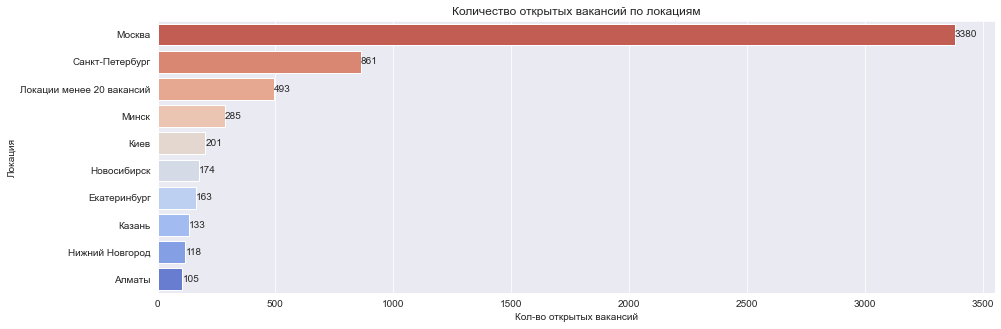

         1 место: Москва (3380)
         2 место: Санкт-Петербург (861)
         3 место: Локации менее 20 вакансий (493)
         4 место: Минск (285)
         5 место: Киев (201)
         6 место: Новосибирск (174)
         7 место: Екатеринбург (163)
         8 место: Казань (133)
         9 место: Нижний Новгород (118)
        10 место: Алматы (105)

Доля лидера Москва: общая = 52.75%, в топ-рейтинге = 57.16%

Лидеры, занимающие первые 25% в общем рейтинге: ['Москва', 'Санкт-Петербург']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Москва', 'Санкт-Петербург']


In [32]:
draw_barplot('id', 'area_name', grp, 
             title="Количество открытых вакансий по локациям", 
             xlabel="Кол-во открытых вакансий", 
             ylabel="Локация", TOP=10)

In [33]:
data = data_extended[(data_extended.archived==False) &
                    (data_extended.area_name=="Москва")]
data = data.merge(employers[['employer_id','type', 'site_url', 'industries', 'open_vacancies']], 
                                  on="employer_id", how="left")

## GEODATA VIZUALIZATION

В данных присутствуют географические координаты адресов компаний и ближайших станций метро. Будет интересно посмотреть на различную статистику на карте. Но прежде выясним какая доля данных содержит сведения о координатах.

In [34]:
mapbox_token = load_list('MAPBOX_ACCESS_TOKEN')

In [35]:
data[['address_lat','address_lng','address_metro_lat','address_metro_lng']] = data[['address_lat','address_lng',
                                                                                    'address_metro_lat',
                                                                                    'address_metro_lng']].fillna(999)
print("Доля вакансий с координатами адреса: {:.4f}".format(data[data.address_lat==999]['id'].count()/data.shape[0]))
print("Доля вакансий с координатами метро: {:.4f}".format(data[data.address_metro_lat==999]['id'].count()/data.shape[0]))

grp = data.groupby(["employer_name", "address_lat", "address_lng"])["id"].count().reset_index()
print("Доля компаний с координатами адреса: {:.4f}".format(grp[grp.address_lat==999]['id'].count()/grp.shape[0]))
grp = data.groupby(["employer_name", "address_metro_lat", "address_metro_lng"])["id"].count().reset_index()
print("Доля компаний с координатами метро: {:.4f}".format(grp[grp.address_metro_lat==999]['id'].count()/grp.shape[0]))

Доля вакансий с координатами адреса: 0.5568
Доля вакансий с координатами метро: 0.5911
Доля компаний с координатами адреса: 0.4557
Доля компаний с координатами метро: 0.5326


In [36]:
def draw_geomap_clusters(data, properties, latcol, loncol, zoom):
    points = df_to_geojson(data, 
                       properties=properties,
                       lat=latcol, lon=loncol, precision=3)

    color_stops = create_color_stops([1,10,50,100,200], colors='Greens')

    viz = ClusteredCircleViz(points,
                             access_token=mapbox_token,
                             color_stops=color_stops,
                             radius_stops=[[1,5], [10, 10], [50, 15], [100, 20], [200, 25]],
                             radius_default=2,
                             cluster_maxzoom=10,
                             cluster_radius=30,
                             label_size=12,
                             opacity=0.9,
                             center=(37.6155600, 55.7522200),
                             zoom=zoom)
    viz.show()

Координаты указаны приблизительно для половины вакансий и компаний. Посмотрим на географию расположения этих вакансий и компаний.

In [37]:
tmp = data_extended[(~data_extended.address_lat.isna())][['address_lat','address_lng', 'id', 'employer_name']]
grp = tmp.groupby(['address_lat','address_lng', 'employer_name'])['employer_name'].nunique().rename('emp_cnt').reset_index()
print("География вакансий аналитика данных в мире")
draw_geomap_clusters(grp, properties=['emp_cnt'], latcol='address_lat', loncol='address_lng', zoom=3)

tmp = data[(data.address_metro_lat!=999)][['address_metro_lat','address_metro_lng', 'id']]
print("География открытых вакансий аналитика данных в Москве - метро")
draw_geomap_clusters(tmp, properties=['id'], latcol='address_metro_lat', loncol='address_metro_lng', zoom=9.6)

tmp = data[(data.address_lat!=999)][['address_lat','address_lng', 'id', 'employer_name']]
grp = tmp.groupby(['address_lat','address_lng', 'employer_name'])['employer_name'].nunique().rename('emp_cnt').reset_index()
print("География работодателей с вакансиями аналитика данных в Москве - адреса")
draw_geomap_clusters(grp, properties=['emp_cnt'], latcol='address_lat', loncol='address_lng', zoom=9.6)

География вакансий аналитика данных в мире


География открытых вакансий аналитика данных в Москве - метро


География работодателей с вакансиями аналитика данных в Москве - адреса


## BOOLEAN DATA

In [38]:
bool_cols = list(data.select_dtypes(include='bool').columns)
bool_cols.append("id")

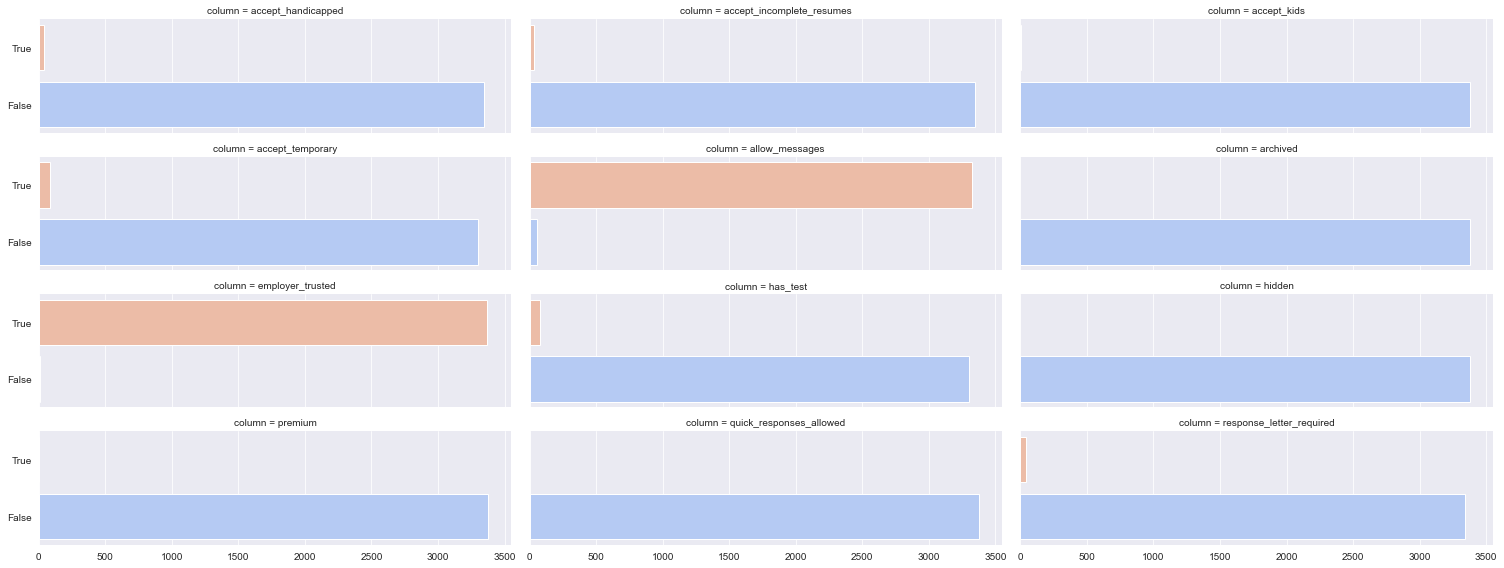

In [39]:
df = data[bool_cols]
df2 = df.melt(id_vars=['id'], var_name='column')
df3 = df2.groupby(['column','value'])['id'].count().reset_index()


g = sns.FacetGrid(data=df3, col='column',col_wrap=3, height=2, aspect=3.5)
plt.ticklabel_format(style='plain', axis='y')
g.map_dataframe(sns.barplot, y='value', x='id', order=[True, False], palette="coolwarm_r", orient='h')

In [40]:
bool_cols.remove("id")
data.drop(columns=bool_cols, inplace=True)

## EMPLOYER

### Рейтинг по открытым вакансиям

In [43]:
# import textwrap

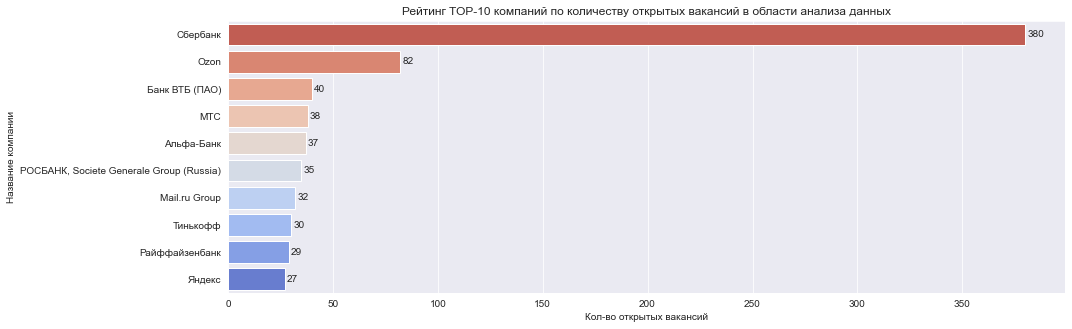

         1 место: Сбербанк (380) [industries: Банк]
         2 место: Ozon (82) [industries: Курьерская, почтовая доставка, Складские услуги, Интернет-магазин, Туристические компании]
         3 место: Банк ВТБ (ПАО) (40) [industries: Управляющая, инвестиционная компания (управление активами), Банк]
         4 место: МТС (38) [industries: Мобильная связь]
         5 место: Альфа-Банк (37) [industries: Банк]
         6 место: РОСБАНК, Societe Generale Group (Russia) (35) [industries: Банк]
         7 место: Mail.ru Group (32) [industries: Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее), Разработка программного обеспечения, Маркетинговые, рекламные, BTL, дизайнерские, Event-, PR-агентства, организация выставок]
         8 место: Тинькофф (30) [industries: Коллекторская деятельность, Банк, Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательны

In [44]:
TOP=10
grp = data[~data.open_vacancies.isna()]
grp['industries'] = grp['industries'].map(tuple)
grp = grp.groupby(['employer_id', 'employer_name','industries']).agg({'id':'count','open_vacancies':'max'}).\
                                        reset_index().sort_values(by="id", ascending=False)
draw_barplot('id', 'employer_name', grp, 
             title=f"Рейтинг TOP-{TOP} компаний по количеству открытых вакансий в области анализа данных", 
             xlabel="Кол-во открытых вакансий", 
             ylabel="Название компании", extra_info="industries", TOP=TOP)

## Рейтинг отраслей компаний

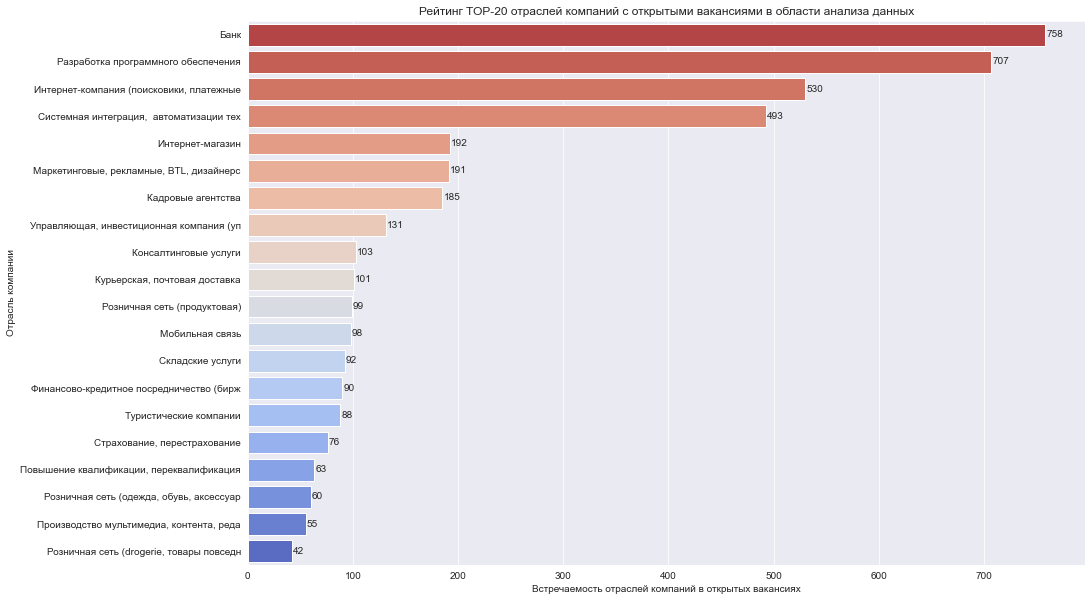

         1 место: Банк (758)
         2 место: Разработка программного обеспечения (707)
         3 место: Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее) (530)
         4 место: Системная интеграция,  автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг (493)
         5 место: Интернет-магазин (192)
         6 место: Маркетинговые, рекламные, BTL, дизайнерские, Event-, PR-агентства, организация выставок (191)
         7 место: Кадровые агентства (185)
         8 место: Управляющая, инвестиционная компания (управление активами) (131)
         9 место: Консалтинговые услуги (103)
        10 место: Курьерская, почтовая доставка (101)
        11 место: Розничная сеть (продуктовая) (99)
        12 место: Мобильная связь (98)
        13 место: Складские услуги (92)
        14 место: Финансово-кредитное посредничество (биржа, брокерская деятельность, выпуск и обслуживание к

In [45]:
TOP=20
all_industries =  data['industries'].explode().dropna()
cnt = Counter(list(all_industries)).most_common()
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} отраслей компаний с открытыми вакансиями в области анализа данных", 
             xlabel="Встречаемость отраслей компаний в открытых вакансиях", 
             ylabel="Отрасль компании", TOP=TOP)

## PHRASES SEARCH

In [46]:
all_sentences = [sent for sent in list(data['desc_sentences']) for sent in sent]

## Комфортный офис

In [47]:
# get_words_before(all_sentences, "офис", "office", words_before='1')

In [48]:
# save_list(search_phrases, 'is_comf_office')
search_phrases  = load_list('is_comf_office')
data['is_comf_office'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)
print(f"Количество вакансий с комфортным офисом: {len(data[data['is_comf_office']==True])}")

Количество вакансий с комфортным офисом: 629


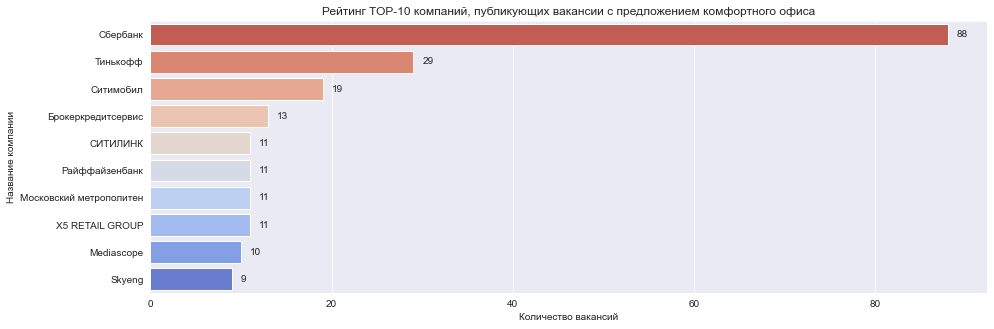

         1 место: Сбербанк (88)
         2 место: Тинькофф (29)
         3 место: Ситимобил (19)
         4 место: Брокеркредитсервис (13)
         5 место: СИТИЛИНК (11)
         6 место: Райффайзенбанк (11)
         7 место: Московский метрополитен (11)
         8 место: X5 RETAIL GROUP (11)
         9 место: Mediascope (10)
        10 место: Skyeng (9)

Доля лидера Сбербанк: общая = 13.99%, в топ-рейтинге = 41.51%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'Тинькофф', 'Ситимобил', 'Брокеркредитсервис', 'СИТИЛИНК']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'Тинькофф']


In [49]:
TOP=10
grp = data[data['is_comf_office']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с предложением комфортного офиса", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## Удаленная работа

In [50]:
# get_words_before(all_sentences, "удалённый", "remote", words_before='1')

Фразы с упоминанием любой удаленной работы

In [51]:
# save_list(any_remote_phrases, 'is_any_remote')
any_remote_phrases  = load_list('is_any_remote')
data['is_any_remote'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=any_remote_phrases)

Фразы с упоминанием частичной, возможной или временной удалёнки

In [52]:
# save_list(partially_remote_phrases, 'is_partially_remote')
partially_remote_phrases  = load_list('is_partially_remote')
data['is_partially_remote'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=partially_remote_phrases)

Фразы с полностью удаленным режимом

In [53]:
# save_list(fully_remote_phrases, 'is_fully_remote')
fully_remote_phrases  = load_list('is_fully_remote')
data['is_fully_remote'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=fully_remote_phrases)

In [54]:
print(f"Количество вакансий с упоминанием удалённой работы: {len(data[data['is_any_remote']==True])}")
print(f"Количество вакансий с упоминанием частичной, возможной или временной удалённой работы: {len(data[data['is_partially_remote']==True])}")
print(f"Количество вакансий с упоминанием полностью удалённой работы: {len(data[data['is_fully_remote']==True])}")

Количество вакансий с упоминанием удалённой работы: 933
Количество вакансий с упоминанием частичной, возможной или временной удалённой работы: 312
Количество вакансий с упоминанием полностью удалённой работы: 95


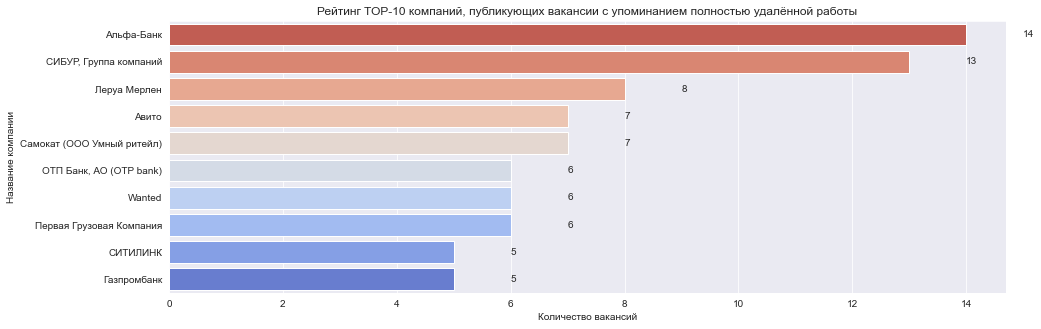

         1 место: Альфа-Банк (14)
         2 место: СИБУР, Группа компаний (13)
         3 место: Леруа Мерлен (8)
         4 место: Авито (7)
         5 место: Самокат (ООО Умный ритейл) (7)
         6 место: ОТП Банк, АО (OTP bank) (6)
         7 место: Wanted (6)
         8 место: Первая Грузовая Компания (6)
         9 место: СИТИЛИНК (5)
        10 место: Газпромбанк (5)

Доля лидера Альфа-Банк: общая = 3.55%, в топ-рейтинге = 18.18%

Лидеры, занимающие первые 25% в общем рейтинге: ['Альфа-Банк', 'СИБУР, Группа компаний', 'Леруа Мерлен', 'Авито', 'Самокат (ООО Умный ритейл)', 'ОТП Банк, АО (OTP bank)', 'Wanted', 'Первая Грузовая Компания', 'СИТИЛИНК', 'Газпромбанк', 'Selecty', 'КОРУС Консалтинг', 'КАЗАНЬЭКСПРЕСС ФУЛФИЛМЕНТ', 'ANCOR', 'Перекресток Впрок', 'Райффайзен Лайф']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Альфа-Банк', 'СИБУР, Группа компаний']


In [55]:
TOP=10
grp = data[(data['is_fully_remote']==True) | (data['is_partially_remote']==True)]\
            .groupby(["employer_id", "employer_name"])["employer_id"]\
            .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с упоминанием полностью удалённой работы", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## Оформление по ТК РФ

In [56]:
# get_words_before(all_sentences, "тк рф", "labor code", words_before='1')

In [57]:
# save_list(search_phrases, 'is_labor_code')
search_phrases  = load_list('is_labor_code')
data['is_labor_code'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [58]:
search_len = len(data[data['is_labor_code']==True])
print("Количество вакансий с трудоустройством по ТК РФ: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с трудоустройством по ТК РФ: 1076 (31.83%) 


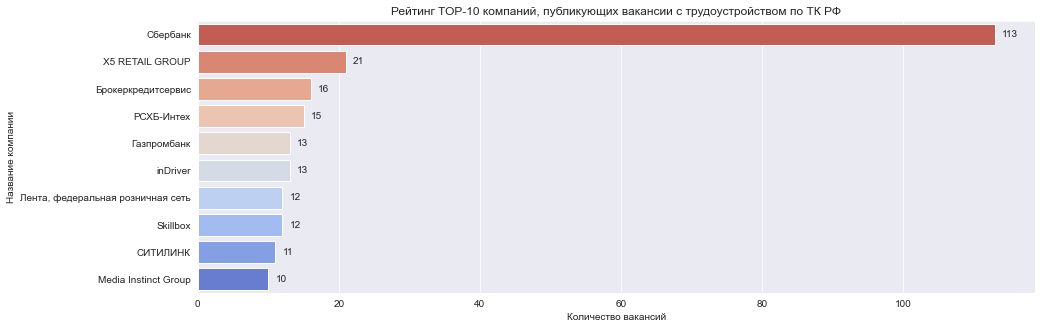

         1 место: Сбербанк (113)
         2 место: X5 RETAIL GROUP (21)
         3 место: Брокеркредитсервис (16)
         4 место: РСХБ-Интех (15)
         5 место: Газпромбанк (13)
         6 место: inDriver (13)
         7 место: Лента, федеральная розничная сеть (12)
         8 место: Skillbox (12)
         9 место: СИТИЛИНК (11)
        10 место: Media Instinct Group (10)

Доля лидера Сбербанк: общая = 10.52%, в топ-рейтинге = 47.88%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'X5 RETAIL GROUP', 'Брокеркредитсервис', 'РСХБ-Интех', 'Газпромбанк', 'inDriver', 'Лента, федеральная розничная сеть', 'Skillbox', 'СИТИЛИНК', 'Media Instinct Group', 'Московский метрополитен', 'Перекресток Впрок', 'Иннотех, Группа компаний', 'СберЛогистика']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'X5 RETAIL GROUP']


In [59]:
TOP=10
grp = data[data['is_labor_code']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с трудоустройством по ТК РФ", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## Белая зарплата

In [60]:
# get_words_around(all_sentences, "белый", "white", words_before='1', words_after='1')

In [61]:
# get_words_after(all_sentences, "белый", "white",  words_after='1')

In [62]:
# save_list(search_phrases, 'is_white_salary')
search_phrases  = load_list('is_white_salary')
data['is_white_salary'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [63]:
search_len = len(data[data['is_white_salary']==True])
print("Количество вакансий с белой зарплатой: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с белой зарплатой: 524 (15.50%) 


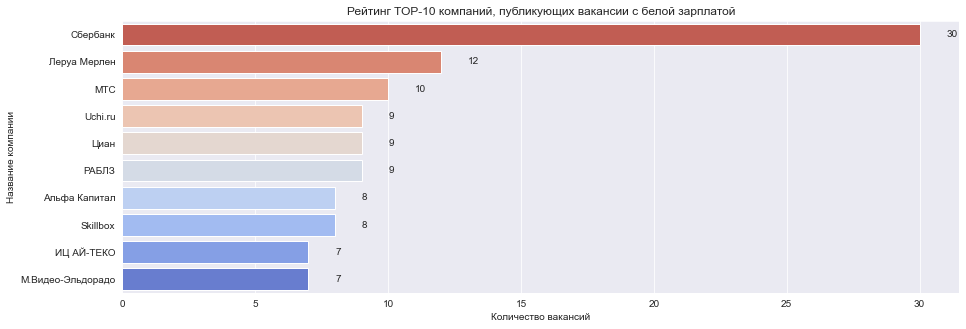

         1 место: Сбербанк (30)
         2 место: Леруа Мерлен (12)
         3 место: МТС (10)
         4 место: Uchi.ru (9)
         5 место: Циан (9)
         6 место: РАБЛЗ (9)
         7 место: Альфа Капитал (8)
         8 место: Skillbox (8)
         9 место: ИЦ АЙ-ТЕКО (7)
        10 место: М.Видео-Эльдорадо (7)

Доля лидера Сбербанк: общая = 5.73%, в топ-рейтинге = 27.52%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'Леруа Мерлен', 'МТС', 'Uchi.ru', 'Циан', 'РАБЛЗ', 'Альфа Капитал', 'Skillbox', 'ИЦ АЙ-ТЕКО', 'М.Видео-Эльдорадо', 'Самокат (ООО Умный ритейл)', 'Selecty', 'КСК-Эйч Ар', 'Сравни.ру']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'Леруа Мерлен']


In [64]:
TOP=10
grp = data[data['is_white_salary']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с белой зарплатой", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## Шаговая доступность метро

In [65]:
# get_words_before(all_sentences, "метро", "subway",  words_before='1')

In [66]:
# get_words_before(all_sentences, "ст метро", "станция метро",  words_before='1')

In [67]:
# save_list(search_phrases, 'is_near_subway')
search_phrases  = load_list('is_near_subway')
data['is_near_subway'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [68]:
search_len = len(data[data['is_near_subway']==True])
print("Количество вакансий рядом с метро: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий рядом с метро: 299 (8.85%) 


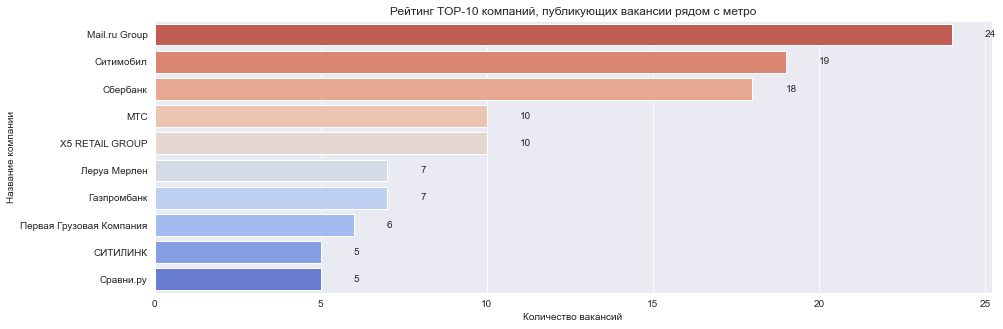

         1 место: Mail.ru Group (24)
         2 место: Ситимобил (19)
         3 место: Сбербанк (18)
         4 место: МТС (10)
         5 место: X5 RETAIL GROUP (10)
         6 место: Леруа Мерлен (7)
         7 место: Газпромбанк (7)
         8 место: Первая Грузовая Компания (6)
         9 место: СИТИЛИНК (5)
        10 место: Сравни.ру (5)

Доля лидера Mail.ru Group: общая = 8.05%, в топ-рейтинге = 21.62%

Лидеры, занимающие первые 25% в общем рейтинге: ['Mail.ru Group', 'Ситимобил', 'Сбербанк', 'МТС', 'X5 RETAIL GROUP']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Mail.ru Group', 'Ситимобил']


In [69]:
TOP=10
grp = data[data['is_near_subway']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии рядом с метро", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## Гибкое начало рабочего дня

In [70]:
# get_words_before(all_sentences, "начало рабочий", "start work",  words_before='2')

In [71]:
# get_words_before(all_sentences, "начало работа", "begin work",  words_before='2')

In [72]:
# get_words_before(all_sentences, "работа начало", "work begin",  words_before='2')

In [73]:
# save_list(search_phrases, 'is_flexible_daystart')
search_phrases  = load_list('is_flexible_daystart')
data['is_flexible_daystart'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [74]:
search_len = len(data[data['is_flexible_daystart']==True])
print("Количество вакансий с гибким началом рабочего дня: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с гибким началом рабочего дня: 245 (7.25%) 


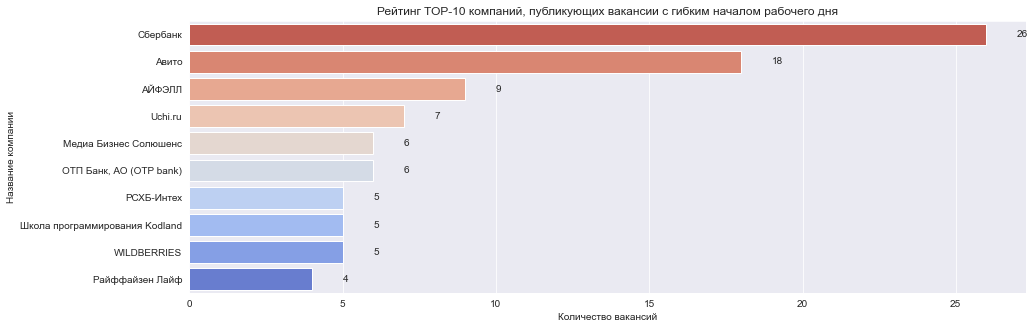

         1 место: Сбербанк (26)
         2 место: Авито (18)
         3 место: АЙФЭЛЛ (9)
         4 место: Uchi.ru (7)
         5 место: Медиа Бизнес Солюшенс (6)
         6 место: ОТП Банк, АО (OTP bank) (6)
         7 место: РСХБ-Интех (5)
         8 место: Школа программирования Kodland (5)
         9 место: WILDBERRIES (5)
        10 место: Райффайзен Лайф (4)

Доля лидера Сбербанк: общая = 10.61%, в топ-рейтинге = 28.57%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'Авито', 'АЙФЭЛЛ', 'Uchi.ru', 'Медиа Бизнес Солюшенс']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'Авито']


In [75]:
TOP=10
grp = data[data['is_flexible_daystart']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с гибким началом рабочего дня", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## Карьерный рост

In [76]:
# get_words_before(all_sentences, "карьера", "career",  words_before='1')

In [77]:
# get_words_before(all_sentences, "карьерный", "career",  words_before='1')

In [78]:
# save_list(search_phrases, 'is_career_growth')
search_phrases  = load_list('is_career_growth')
data['is_career_growth'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases)

In [79]:
search_len = len(data[data['is_career_growth']==True])
print("Количество вакансий с предложением карьерного роста: {} ({:.2f}%) ".format(search_len,search_len/len(data)*100))

Количество вакансий с предложением карьерного роста: 492 (14.56%) 


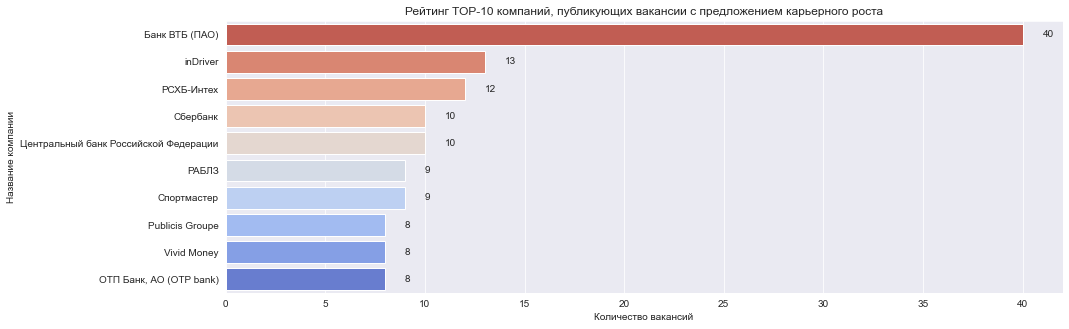

         1 место: Банк ВТБ (ПАО) (40)
         2 место: inDriver (13)
         3 место: РСХБ-Интех (12)
         4 место: Сбербанк (10)
         5 место: Центральный банк Российской Федерации (10)
         6 место: РАБЛЗ (9)
         7 место: Спортмастер (9)
         8 место: Publicis Groupe (8)
         9 место: Vivid Money (8)
        10 место: ОТП Банк, АО (OTP bank) (8)

Доля лидера Банк ВТБ (ПАО): общая = 8.16%, в топ-рейтинге = 31.50%

Лидеры, занимающие первые 25% в общем рейтинге: ['Банк ВТБ (ПАО)', 'inDriver', 'РСХБ-Интех', 'Сбербанк', 'Центральный банк Российской Федерации', 'РАБЛЗ', 'Спортмастер', 'Publicis Groupe', 'Vivid Money', 'ОТП Банк, АО (OTP bank)']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Банк ВТБ (ПАО)', 'inDriver']


In [80]:
TOP=10
grp = data[data['is_career_growth']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с предложением карьерного роста", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## Бесплатные бонусы

In [81]:
# get_words_after(all_sentences, "счёт компания", "счёт работодатель",  words_after='3')

In [82]:
# get_words_after(all_sentences, "бесплатно", "free",  words_after='2')

In [83]:
# get_words_after(all_sentences, "бесплатный", "free",  words_after='2')

In [84]:
# get_words_before(all_sentences, "счёт компания", "счёт работодатель",  words_before='2')

In [85]:
# save_list(search_phrases_food, 'is_free_food')
# save_list(search_phrases_drink, 'is_free_drink')
# save_list(search_phrases_learning, 'is_free_learning')
# save_list(search_phrases_gym, 'is_free_gym')
# save_list(search_phrases_parking, 'is_free_parking')
# save_list(search_phrases_transport, 'is_free_transport')
# save_list(search_phrases_dms, 'is_free_dms')
# save_list(search_phrases_mobile, 'is_free_mobile')
search_phrases_food  = load_list('is_free_food')
search_phrases_drink  = load_list('is_free_drink')
search_phrases_learning  = load_list('is_free_learning')
search_phrases_gym  = load_list('is_free_gym')
search_phrases_parking  = load_list('is_free_parking')
search_phrases_transport  = load_list('is_free_transport')
search_phrases_dms  = load_list('is_free_dms')
search_phrases_mobile  = load_list('is_free_mobile')

data['is_free_food'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_food)
data['is_free_drink'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_drink)
data['is_free_learning'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_learning)
data['is_free_gym'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_gym)
data['is_free_parking'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_parking)
data['is_free_transport'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_transport)
data['is_free_dms'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_dms)
data['is_free_mobile'] = data['desc_lemm'].apply(check_frase_in_text, search_phrases=search_phrases_mobile)

In [86]:
print("Количество вакансий с предложением бесплатной еды: {} ({:.2f}%)".format(len(data[data['is_free_food']==True]),
                                              len(data[data['is_free_food']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатных напитков: {} ({:.2f}%)".format(len(data[data['is_free_drink']==True]),
                                              len(data[data['is_free_drink']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатного обучения: {} ({:.2f}%)".format(len(data[data['is_free_learning']==True]),
                                              len(data[data['is_free_learning']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатного фитнеса: {} ({:.2f}%)".format(len(data[data['is_free_gym']==True]),
                                              len(data[data['is_free_gym']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатной парковки: {} ({:.2f}%)".format(len(data[data['is_free_parking']==True]),
                                              len(data[data['is_free_parking']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатного проезда: {} ({:.2f}%)".format(len(data[data['is_free_transport']==True]),
                                              len(data[data['is_free_transport']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатных медуслуг: {} ({:.2f}%)".format(len(data[data['is_free_dms']==True]),
                                              len(data[data['is_free_dms']==True])/len(data)*100))
print("Количество вакансий с предложением бесплатной мобильной связи: {} ({:.2f}%)".format(len(data[data['is_free_mobile']==True]),
                                              len(data[data['is_free_mobile']==True])/len(data)*100))

Количество вакансий с предложением бесплатной еды: 122 (3.61%)
Количество вакансий с предложением бесплатных напитков: 29 (0.86%)
Количество вакансий с предложением бесплатного обучения: 327 (9.67%)
Количество вакансий с предложением бесплатного фитнеса: 182 (5.38%)
Количество вакансий с предложением бесплатной парковки: 105 (3.11%)
Количество вакансий с предложением бесплатного проезда: 21 (0.62%)
Количество вакансий с предложением бесплатных медуслуг: 10 (0.30%)
Количество вакансий с предложением бесплатной мобильной связи: 6 (0.18%)


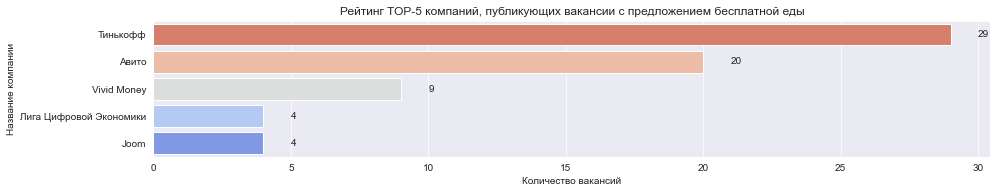

         1 место: Тинькофф (29)
         2 место: Авито (20)
         3 место: Vivid Money (9)
         4 место: Лига Цифровой Экономики (4)
         5 место: Joom (4)

Доля лидера Тинькофф: общая = 23.77%, в топ-рейтинге = 43.94%

Лидеры, занимающие первые 25% в общем рейтинге: ['Тинькофф', 'Авито']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Тинькофф', 'Авито']


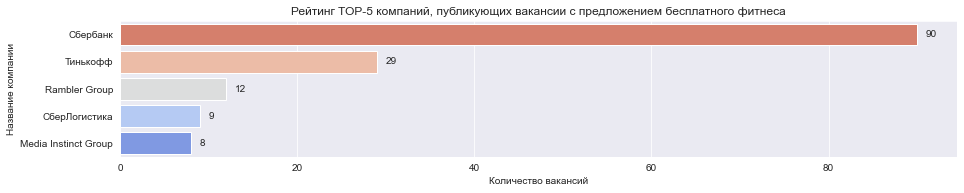

         1 место: Сбербанк (90)
         2 место: Тинькофф (29)
         3 место: Rambler Group (12)
         4 место: СберЛогистика (9)
         5 место: Media Instinct Group (8)

Доля лидера Сбербанк: общая = 49.45%, в топ-рейтинге = 60.81%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'Тинькофф']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'Тинькофф']


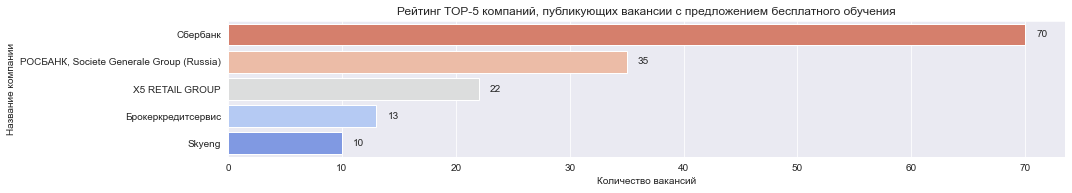

         1 место: Сбербанк (70)
         2 место: РОСБАНК, Societe Generale Group (Russia) (35)
         3 место: X5 RETAIL GROUP (22)
         4 место: Брокеркредитсервис (13)
         5 место: Skyeng (10)

Доля лидера Сбербанк: общая = 21.54%, в топ-рейтинге = 46.67%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'РОСБАНК, Societe Generale Group (Russia)']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'РОСБАНК, Societe Generale Group (Russia)']


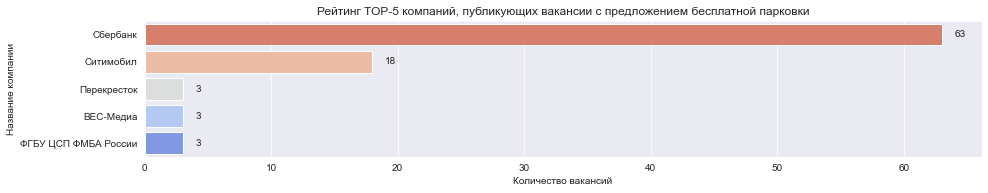

         1 место: Сбербанк (63)
         2 место: Ситимобил (18)
         3 место: Перекресток (3)
         4 место: ВЕС-Медиа (3)
         5 место: ФГБУ ЦСП ФМБА России (3)

Доля лидера Сбербанк: общая = 60.00%, в топ-рейтинге = 70.00%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'Ситимобил']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'Ситимобил']


In [87]:
TOP=5
grp = data[data['is_free_food']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с предложением бесплатной еды", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

grp = data[data['is_free_gym']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с предложением бесплатного фитнеса", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

grp = data[data['is_free_learning']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с предложением бесплатного обучения", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)


grp = data[data['is_free_parking']==True].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии с предложением бесплатной парковки", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

## TOP KEY SKILLS

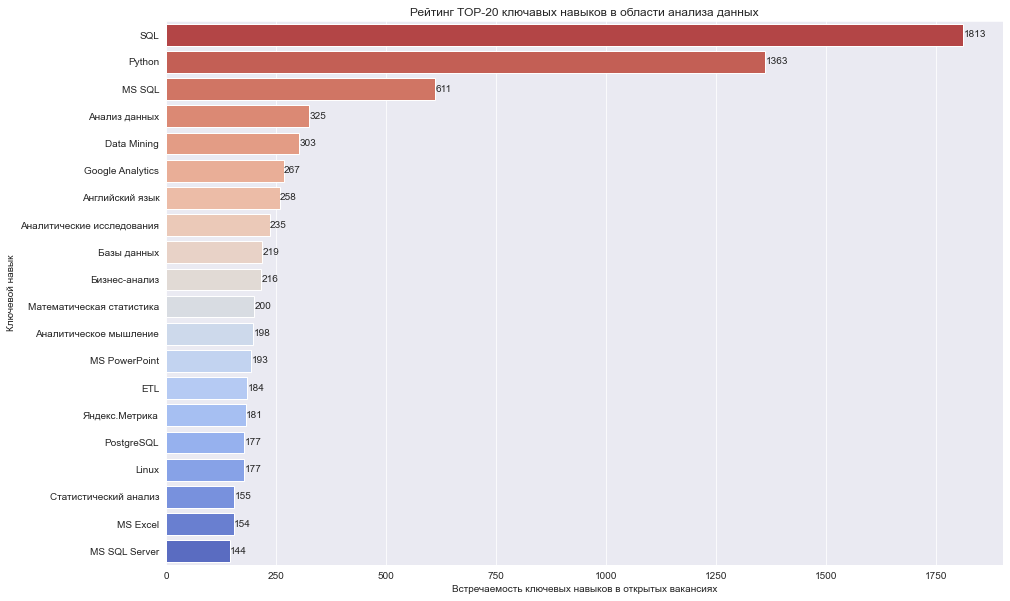

         1 место: SQL (1813)
         2 место: Python (1363)
         3 место: MS SQL (611)
         4 место: Анализ данных (325)
         5 место: Data Mining (303)
         6 место: Google Analytics (267)
         7 место: Английский язык (258)
         8 место: Аналитические исследования (235)
         9 место: Базы данных (219)
        10 место: Бизнес-анализ (216)
        11 место: Математическая статистика (200)
        12 место: Аналитическое мышление (198)
        13 место: MS PowerPoint (193)
        14 место: ETL (184)
        15 место: Яндекс.Метрика (181)
        16 место: PostgreSQL (177)
        17 место: Linux (177)
        18 место: Статистический анализ (155)
        19 место: MS Excel (154)
        20 место: MS SQL Server (144)

Доля лидера SQL: общая = 11.27%, в топ-рейтинге = 24.59%

Лидеры, занимающие первые 25% в общем рейтинге: ['SQL', 'Python', 'MS SQL', 'Анализ данных']

Лидеры, занимающие первые 25% в топ-рейтинге: ['SQL', 'Python']


In [88]:
TOP=20
all_key_skills = [skill for skill in list(data['key_skills']) for skill in skill]
cnt = Counter(list(all_key_skills)).most_common()
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} ключавых навыков в области анализа данных", 
             xlabel="Встречаемость ключевых навыков в открытых вакансиях", 
             ylabel="Ключевой навык", TOP=TOP)

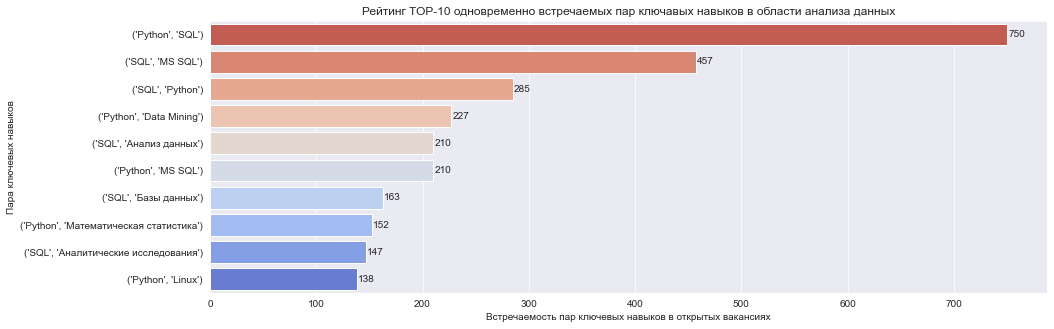

         1 место: ('Python', 'SQL') (750)
         2 место: ('SQL', 'MS SQL') (457)
         3 место: ('SQL', 'Python') (285)
         4 место: ('Python', 'Data Mining') (227)
         5 место: ('SQL', 'Анализ данных') (210)
         6 место: ('Python', 'MS SQL') (210)
         7 место: ('SQL', 'Базы данных') (163)
         8 место: ('Python', 'Математическая статистика') (152)
         9 место: ('SQL', 'Аналитические исследования') (147)
        10 место: ('Python', 'Linux') (138)

Доля лидера ('Python', 'SQL'): общая = 1.40%, в топ-рейтинге = 27.38%

Лидеры, занимающие первые 10% в общем рейтинге: [('Python', 'SQL'), ('SQL', 'MS SQL'), ('SQL', 'Python'), ('Python', 'Data Mining'), ('SQL', 'Анализ данных'), ('Python', 'MS SQL'), ('SQL', 'Базы данных'), ('Python', 'Математическая статистика'), ('SQL', 'Аналитические исследования'), ('Python', 'Linux'), ('SQL', 'Data Mining'), ('SQL', 'Бизнес-анализ'), ('Google Analytics', 'Яндекс.Метрика'), ('SQL', 'Английский язык'), ('Python', 'Анали

In [89]:
TOP=10
tmp = occurences_counter(data.key_skills, num=2)
cnt_data = pd.DataFrame(tmp.most_common())
draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} одновременно встречаемых пар ключавых навыков в области анализа данных", 
             xlabel="Встречаемость пар ключевых навыков в открытых вакансиях", 
             ylabel="Пара ключевых навыков", TOP=TOP, rate=10)

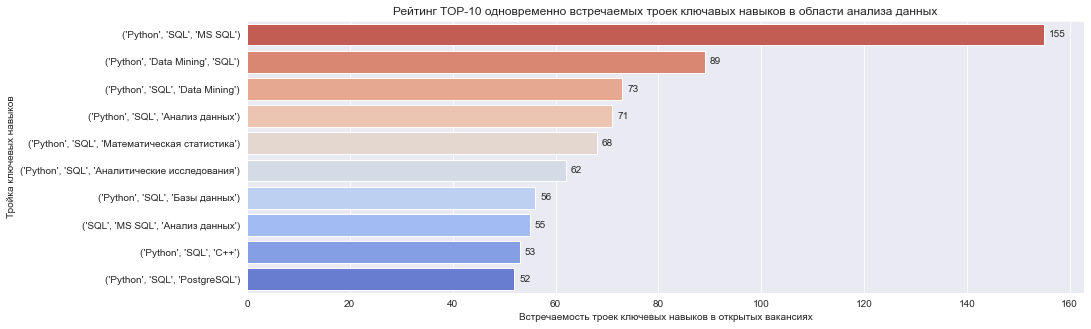

         1 место: ('Python', 'SQL', 'MS SQL') (155)
         2 место: ('Python', 'Data Mining', 'SQL') (89)
         3 место: ('Python', 'SQL', 'Data Mining') (73)
         4 место: ('Python', 'SQL', 'Анализ данных') (71)
         5 место: ('Python', 'SQL', 'Математическая статистика') (68)
         6 место: ('Python', 'SQL', 'Аналитические исследования') (62)
         7 место: ('Python', 'SQL', 'Базы данных') (56)
         8 место: ('SQL', 'MS SQL', 'Анализ данных') (55)
         9 место: ('Python', 'SQL', 'C++') (53)
        10 место: ('Python', 'SQL', 'PostgreSQL') (52)

Доля лидера ('Python', 'SQL', 'MS SQL'): общая = 0.11%, в топ-рейтинге = 21.12%

Лидеры, занимающие первые 1% в общем рейтинге: [('Python', 'SQL', 'MS SQL'), ('Python', 'Data Mining', 'SQL'), ('Python', 'SQL', 'Data Mining'), ('Python', 'SQL', 'Анализ данных'), ('Python', 'SQL', 'Математическая статистика'), ('Python', 'SQL', 'Аналитические исследования'), ('Python', 'SQL', 'Базы данных'), ('SQL', 'MS SQL', 'Анализ 

In [90]:
top=20
tmp = occurences_counter(data.key_skills, num=3)
cnt_data = pd.DataFrame(tmp.most_common())
draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} одновременно встречаемых троек ключавых навыков в области анализа данных", 
             xlabel="Встречаемость троек ключевых навыков в открытых вакансиях", 
             ylabel="Тройка ключевых навыков", TOP=TOP, rate=1)

## TOP KEY PHRASES

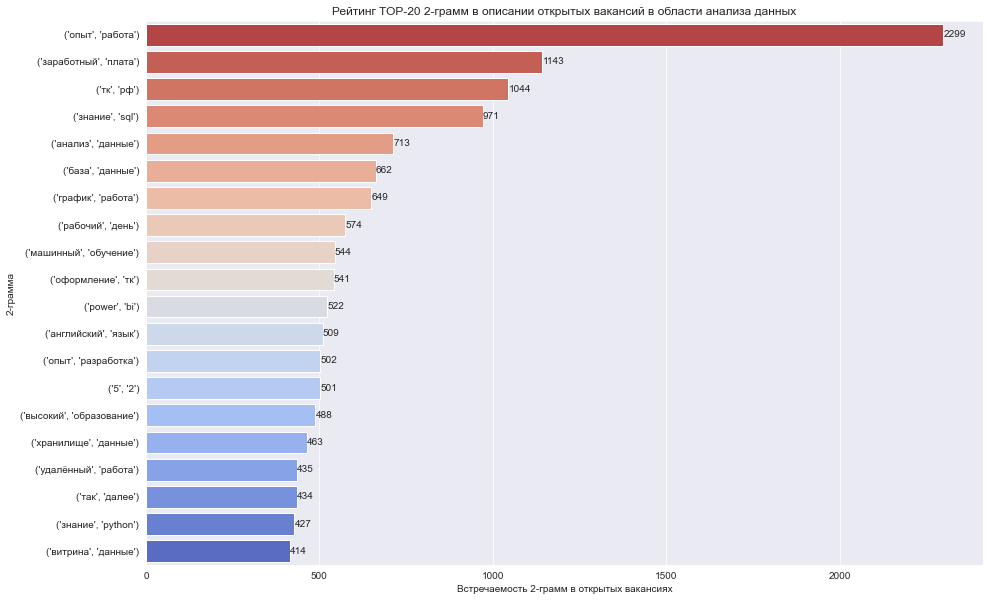

         1 место: ('опыт', 'работа') (2299)
         2 место: ('заработный', 'плата') (1143)
         3 место: ('тк', 'рф') (1044)
         4 место: ('знание', 'sql') (971)
         5 место: ('анализ', 'данные') (713)
         6 место: ('база', 'данные') (662)
         7 место: ('график', 'работа') (649)
         8 место: ('рабочий', 'день') (574)
         9 место: ('машинный', 'обучение') (544)
        10 место: ('оформление', 'тк') (541)
        11 место: ('power', 'bi') (522)
        12 место: ('английский', 'язык') (509)
        13 место: ('опыт', 'разработка') (502)
        14 место: ('5', '2') (501)
        15 место: ('высокий', 'образование') (488)
        16 место: ('хранилище', 'данные') (463)
        17 место: ('удалённый', 'работа') (435)
        18 место: ('так', 'далее') (434)
        19 место: ('знание', 'python') (427)
        20 место: ('витрина', 'данные') (414)

Доля лидера ('опыт', 'работа'): общая = 2.04%, в топ-рейтинге = 16.62%

Лидеры, занимающие первые 10% в общ

In [91]:
TOP=20
tmp = Counter([ngram for ngram in data['good_key_phrases_2grams'] for ngram in ngram])
cnt_data = pd.DataFrame(tmp.most_common())
draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} 2-грамм в описании открытых вакансий в области анализа данных", 
             xlabel="Встречаемость 2-грамм в открытых вакансиях", 
             ylabel="2-грамма", TOP=TOP, rate=10)

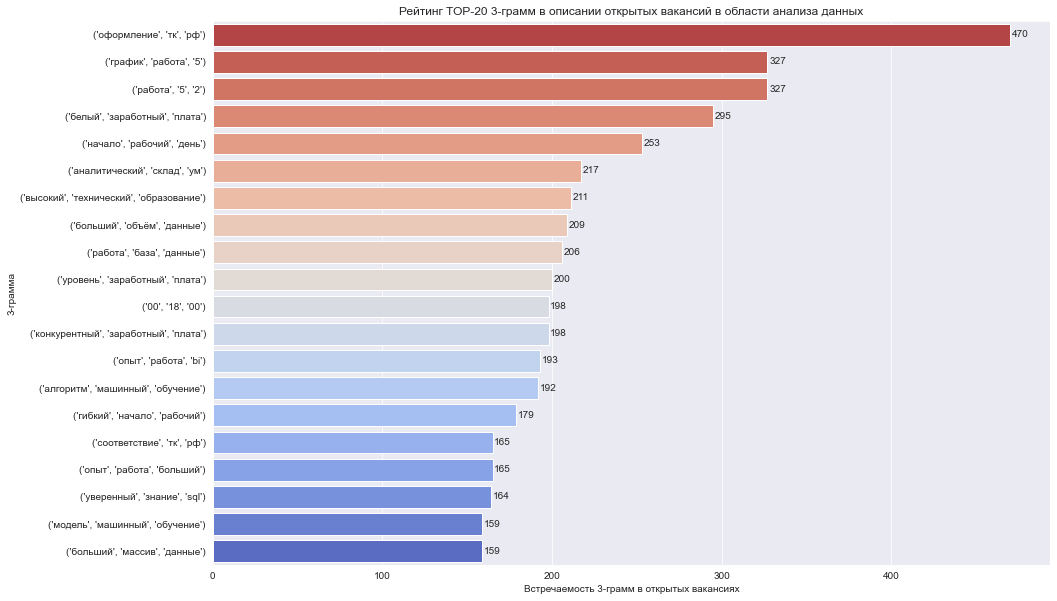

         1 место: ('оформление', 'тк', 'рф') (470)
         2 место: ('график', 'работа', '5') (327)
         3 место: ('работа', '5', '2') (327)
         4 место: ('белый', 'заработный', 'плата') (295)
         5 место: ('начало', 'рабочий', 'день') (253)
         6 место: ('аналитический', 'склад', 'ум') (217)
         7 место: ('высокий', 'технический', 'образование') (211)
         8 место: ('больший', 'объём', 'данные') (209)
         9 место: ('работа', 'база', 'данные') (206)
        10 место: ('уровень', 'заработный', 'плата') (200)
        11 место: ('00', '18', '00') (198)
        12 место: ('конкурентный', 'заработный', 'плата') (198)
        13 место: ('опыт', 'работа', 'bi') (193)
        14 место: ('алгоритм', 'машинный', 'обучение') (192)
        15 место: ('гибкий', 'начало', 'рабочий') (179)
        16 место: ('соответствие', 'тк', 'рф') (165)
        17 место: ('опыт', 'работа', 'больший') (165)
        18 место: ('уверенный', 'знание', 'sql') (164)
        19 место: 

In [92]:
TOP=20
tmp = Counter([ngram for ngram in data['good_key_phrases_3grams'] for ngram in ngram])
cnt_data = pd.DataFrame(tmp.most_common())
draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} 3-грамм в описании открытых вакансий в области анализа данных", 
             xlabel="Встречаемость 3-грамм в открытых вакансиях", 
             ylabel="3-грамма", TOP=TOP, rate=10)

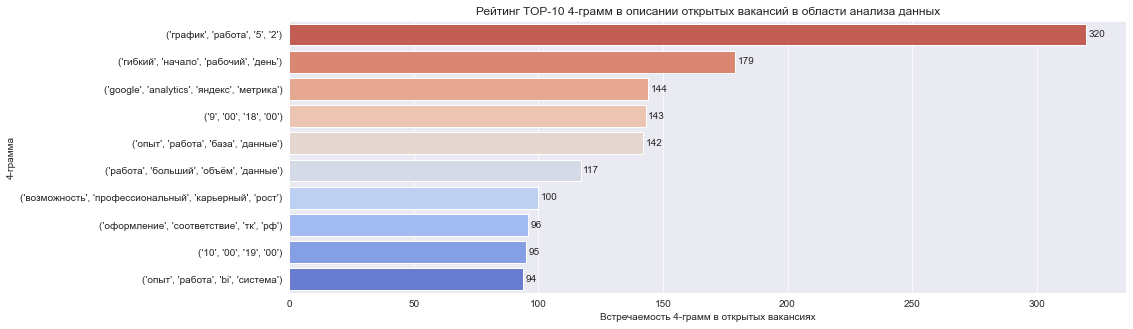

         1 место: ('график', 'работа', '5', '2') (320)
         2 место: ('гибкий', 'начало', 'рабочий', 'день') (179)
         3 место: ('google', 'analytics', 'яндекс', 'метрика') (144)
         4 место: ('9', '00', '18', '00') (143)
         5 место: ('опыт', 'работа', 'база', 'данные') (142)
         6 место: ('работа', 'больший', 'объём', 'данные') (117)
         7 место: ('возможность', 'профессиональный', 'карьерный', 'рост') (100)
         8 место: ('оформление', 'соответствие', 'тк', 'рф') (96)
         9 место: ('10', '00', '19', '00') (95)
        10 место: ('опыт', 'работа', 'bi', 'система') (94)

Доля лидера ('график', 'работа', '5', '2'): общая = 5.91%, в топ-рейтинге = 22.38%

Лидеры, занимающие первые 10% в общем рейтинге: [('график', 'работа', '5', '2'), ('гибкий', 'начало', 'рабочий', 'день'), ('google', 'analytics', 'яндекс', 'метрика')]

Лидеры, занимающие первые 10% в топ-рейтинге: [('график', 'работа', '5', '2'), ('гибкий', 'начало', 'рабочий', 'день')]


In [93]:
TOP=10
tmp = Counter([ngram for ngram in data['good_key_phrases_4grams'] for ngram in ngram])
cnt_data = pd.DataFrame(tmp.most_common())
draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} 4-грамм в описании открытых вакансий в области анализа данных", 
             xlabel="Встречаемость 4-грамм в открытых вакансиях", 
             ylabel="4-грамма", TOP=TOP, rate=10)

## TOP JOB NAMES

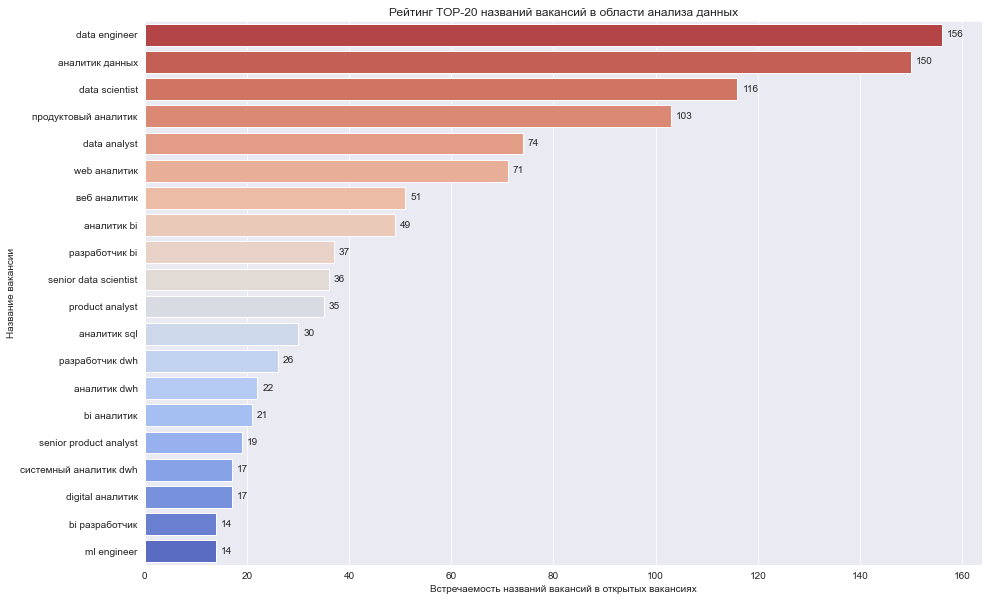

         1 место: data engineer (156)
         2 место: аналитик данных (150)
         3 место: data scientist (116)
         4 место: продуктовый аналитик (103)
         5 место: data analyst (74)
         6 место: web аналитик (71)
         7 место: веб аналитик (51)
         8 место: аналитик bi (49)
         9 место: разработчик bi (37)
        10 место: senior data scientist (36)
        11 место: product analyst (35)
        12 место: аналитик sql (30)
        13 место: разработчик dwh (26)
        14 место: аналитик dwh (22)
        15 место: bi аналитик (21)
        16 место: senior product analyst (19)
        17 место: системный аналитик dwh (17)
        18 место: digital аналитик (17)
        19 место: bi разработчик (14)
        20 место: ml engineer (14)

Доля лидера data engineer: общая = 4.62%, в топ-рейтинге = 14.74%

Лидеры, занимающие первые 25% в общем рейтинге: ['data engineer', 'аналитик данных', 'data scientist', 'продуктовый аналитик', 'data analyst', 'web аналит

In [94]:
TOP=20
all_job_names = [name for name in list(data['name'].apply(get_words_only))]
cnt = Counter(list(all_job_names)).most_common()
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title=f"Рейтинг TOP-{TOP} названий вакансий в области анализа данных", 
             xlabel="Встречаемость названий вакансий в открытых вакансиях", 
             ylabel="Название вакансии", TOP=TOP)

## BILLING TYPE

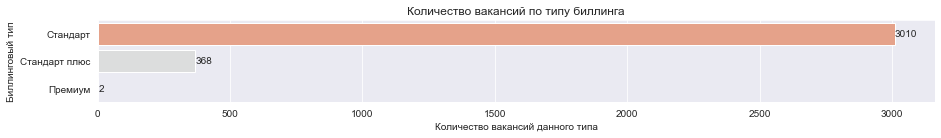

         1 место: Стандарт (3010)
         2 место: Стандарт плюс (368)
         3 место: Премиум (2)

Доля лидера Стандарт: общая = 89.05%, в топ-рейтинге = 89.05%

Лидеры, занимающие первые 25% в общем рейтинге: ['Стандарт', 'Стандарт плюс']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Стандарт', 'Стандарт плюс']


In [95]:
TOP=3
cnt = Counter(list(data.billing_type_name)).most_common()
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по типу биллинга", 
             xlabel="Количество вакансий данного типа", 
             ylabel="Биллинговый тип", TOP=TOP)

### Какой тип биллинга в вакансиях топ-10 компаний

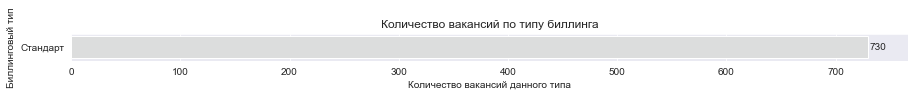

         1 место: Стандарт (730)

Доля лидера Стандарт: общая = 100.00%, в топ-рейтинге = 100.00%

Лидеры, занимающие первые 25% в общем рейтинге: ['Стандарт']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Стандарт']


In [96]:
TOP=10
grp = data[~data.open_vacancies.isna()]
emp_names = grp.groupby(['employer_id', 'employer_name']).agg({'id':'count','open_vacancies':'max'}).\
                                        reset_index().sort_values(by="id", ascending=False)[:10]['employer_name']

cnt = Counter(list(data[data.employer_name.isin(emp_names)]['billing_type_name'])).most_common()
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по типу биллинга", 
             xlabel="Количество вакансий данного типа", 
             ylabel="Биллинговый тип", TOP=TOP)

In [98]:
premium_employers = set(data[data.billing_type_name=="Премиум"]['employer_name'])
", ".join(str(item) for item in premium_employers)

'Makita, Unikoom'

In [100]:
prem_row = data[(data.employer_name=="Makita") & (data.billing_type_name=="Премиум")].iloc[0]
print(prem_row.employer_name)
print(prem_row["name"])
print(f'Ключевые навыки: {prem_row.key_skills}')
print('Стек технологий: ', end="") 
print(", ".join(prem_row.tech_stack))
print('\nКлючевые фразы:')
print(", ".join(prem_row.desc_sentences).replace(", ", "\n"))

Makita
1С программист-аналитик
Ключевые навыки: ['1С: Управление Торговлей', '1С: Бухгалтерия', 'Разработка технических заданий', '1С программирование', 'Обновление конфигурации 1С']
Стек технологий: d, c, bi, r

Ключевые фразы:
обязанность
доработка сопровождение конфигурация 1c так
ч
нетиповой создание отчёт пф так
п
обеспечение обновление релиз так
ч
нетиповой конфигурация
организация обмен данные иб
поиск оптимальный путь решение задача автоматизация бизнес процесс
оценка целесообразность планирование согласование ведение проект доработка смена внедрение сопровождение конфигурация так
ч
привлечение аутсорсинговый компания
консультирование заказчик руководитель структурный подразделение
подготовка создание инструкция пользователь проведение тренинг
требование
опыт 1с программирование 5 год
знание платформа 8
3 конфигурация ут бухгалтерия
знание специфика бизнес сфера оптовый торговля
опыт проектный работа ведение переговоры заказчик формализация требование написание согласование тз


Удаляем мало полезные данные billing_type_name:

In [101]:
data.drop(columns="billing_type_name", inplace=True)

## EMPLOYMENT

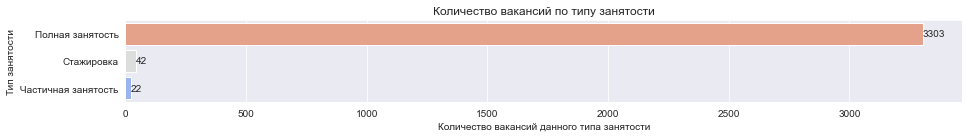

         1 место: Полная занятость (3303)
         2 место: Стажировка (42)
         3 место: Частичная занятость (22)

Доля лидера Полная занятость: общая = 97.72%, в топ-рейтинге = 98.10%

Лидеры, занимающие первые 25% в общем рейтинге: ['Полная занятость', 'Стажировка']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Полная занятость', 'Стажировка']


In [102]:
TOP=3
cnt = Counter(list(data.employment_name)).most_common()
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по типу занятости", 
             xlabel="Количество вакансий данного типа занятости", 
             ylabel="Тип занятости", TOP=TOP)

In [103]:
intern_employers = set(data[data.employment_name=="Стажировка"]['employer_name'])
", ".join(str(item) for item in intern_employers)

'Procter & Gamble, Эмбедика, WorldQuant, Uchi.ru, UniCredit Bank, МАЙНДСЭТ, Банк Хоум Кредит, Домашенко Валерий Юрьевич, ОТП Банк, АО (OTP bank), САС Институт, SAP, Ozon, The Boston Consulting Group, Билайн, РОСБАНК, Societe Generale Group (Russia), сектор образовательных и тренировочных программ, Инфосистемы Джет, Gett, EY (Эрнст энд Янг), Tefal, BOSCH, Сбербанк, СИБУР, Группа компаний, Publicis Groupe, Леруа Мерлен, Align Technology, Т1 Консалтинг'

In [104]:
intern_employers = set(data[data.employment_name=="Частичная занятость"]['employer_name'])
", ".join(str(item) for item in intern_employers)

'SkillExpert, Простой маркетинг, Даблби, Полещук Дмитрий Сергеевич, NXP Semiconductors, Skyeng, Яндекс.Практикум, ХакерЮ, Softdesign, студия, GeekBrains, Skillbox, Zebrainy Limited, Mail IQ (ИП Косенко А. В), Ozon, Отус, Омнимикс, Гудфокаст'

## SALARY TO RUR

In [105]:
data.salary_currency.unique()

array([nan, 'RUR', 'USD', 'EUR'], dtype=object)

In [106]:
RUR = 1.0
KZT = 0.18
UAH = 2.67
USD = 74.69
BYR = 28.67
EUR = 90.3
UZS = 0.0071

In [107]:
data['salary_from_RUR'] = data.apply(lambda x: currency(x['salary_from'], x['salary_currency']), axis=1)
data['salary_to_RUR'] = data.apply(lambda x: currency(x['salary_to'], x['salary_currency']), axis=1)

## Опыт работы

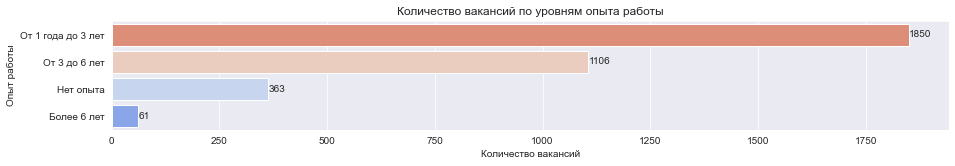

         1 место: От 1 года до 3 лет (1850)
         2 место: От 3 до 6 лет (1106)
         3 место: Нет опыта (363)
         4 место: Более 6 лет (61)

Доля лидера От 1 года до 3 лет: общая = 54.73%, в топ-рейтинге = 54.73%

Лидеры, занимающие первые 25% в общем рейтинге: ['От 1 года до 3 лет', 'От 3 до 6 лет']

Лидеры, занимающие первые 25% в топ-рейтинге: ['От 1 года до 3 лет', 'От 3 до 6 лет']


In [108]:
TOP=5
cnt = Counter(list(data.experience_name)).most_common()
cnt_data = pd.DataFrame(cnt)

draw_barplot(1, 0, cnt_data, 
             title="Количество вакансий по уровням опыта работы", 
             xlabel="Количество вакансий", 
             ylabel="Опыт работы", TOP=TOP)

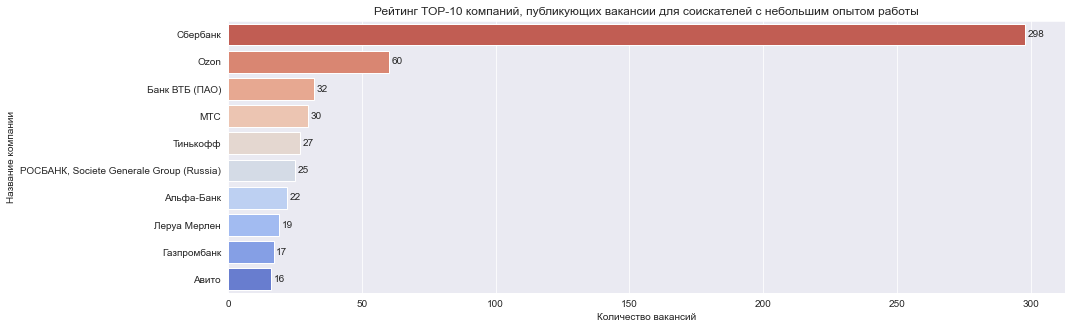

         1 место: Сбербанк (298)
         2 место: Ozon (60)
         3 место: Банк ВТБ (ПАО) (32)
         4 место: МТС (30)
         5 место: Тинькофф (27)
         6 место: РОСБАНК, Societe Generale Group (Russia) (25)
         7 место: Альфа-Банк (22)
         8 место: Леруа Мерлен (19)
         9 место: Газпромбанк (17)
        10 место: Авито (16)

Доля лидера Сбербанк: общая = 13.48%, в топ-рейтинге = 54.58%

Лидеры, занимающие первые 25% в общем рейтинге: ['Сбербанк', 'Ozon', 'Банк ВТБ (ПАО)', 'МТС', 'Тинькофф', 'РОСБАНК, Societe Generale Group (Russia)', 'Альфа-Банк', 'Леруа Мерлен', 'Газпромбанк', 'Авито', 'Райффайзенбанк']

Лидеры, занимающие первые 25% в топ-рейтинге: ['Сбербанк', 'Ozon']


In [109]:
TOP=10
grp = data[data.experience_name.isin(["Нет опыта","От 1 года до 3 лет"])].groupby(["employer_id", "employer_name"])["employer_id"]\
                         .count().rename("cnt").reset_index().sort_values(by="cnt", ascending=False)

draw_barplot("cnt", "employer_name", grp, 
             title=f"Рейтинг TOP-{TOP} компаний, публикующих вакансии для соискателей с небольшим опытом работы", 
             xlabel="Количество вакансий", 
             ylabel="Название компании", TOP=TOP)

<Figure size 1080x360 with 0 Axes>

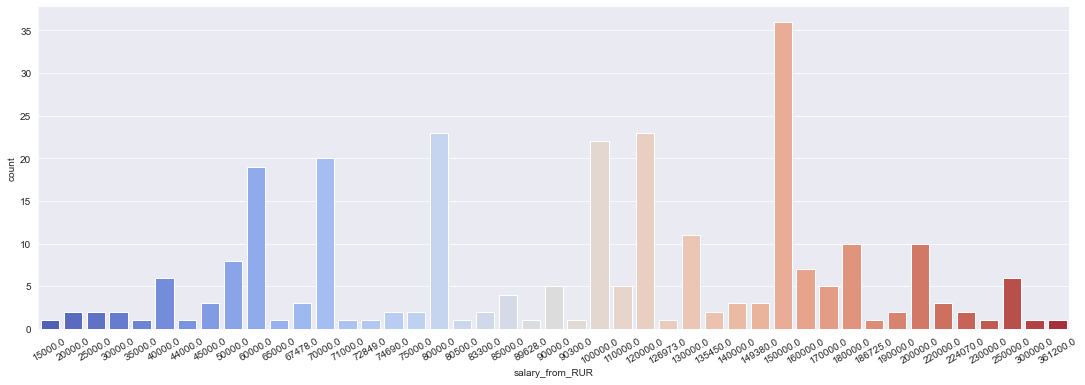

In [110]:
tmp = data[data.experience_name.isin(["Нет опыта","От 1 года до 3 лет"])][['id','salary_from_RUR']]

plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

g = sns.catplot(x="salary_from_RUR", kind="count", palette="coolwarm", data=tmp, aspect=3)
g.set_xticklabels(rotation=30)

plt.show()

<Figure size 1080x360 with 0 Axes>

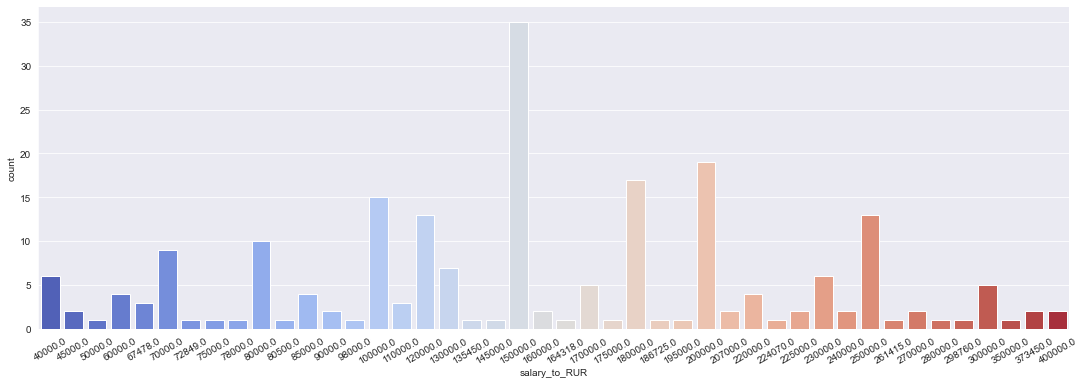

In [111]:
tmp = data[data.experience_name.isin(["Нет опыта","От 1 года до 3 лет"])][['id','salary_to_RUR']]

plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

g = sns.catplot(x="salary_to_RUR", kind="count", palette="coolwarm", data=tmp, aspect=3)
g.set_xticklabels(rotation=30)

plt.show()

In [112]:
data.salary_gross.unique()

array([nan, 0.0, 1.0], dtype=object)

## POSITION GRADES

In [113]:
# def cond(row, text):
#     return text in row.lower()


In [114]:
all_titles = [string for string in data_extended['name'].apply(get_words_only)]
all_titles = flatten_lol([word.lower().split(' ') for word in all_titles])
cnt = Counter(all_titles).most_common(500)
cnt_data = pd.DataFrame(cnt)

In [115]:
data_extended['grade'] = None
heads = ["начальник","руководитель","главный","principal","head","lead","лид","лидер","директор","director","тимлид",
               "chief"] 
seniors = ["senior","sen","сен","сеньор","ведущий","expert","эксперт"]
mids = ["mid","middle","старший"]
juns = ["начинающий","младший","junior","jun"]
interns = ["internship","intern","стажёр","стажер","стажировка"]



for index, row in data_extended.iterrows():
    r = row["name"]
    if cond(r, heads):
        data_extended.at[index, "grade"] = "lead"
    elif ((cond(r, seniors)) & (cond(r, mids)) & (cond(r, juns))):
        data_extended.at[index, "grade"] = "junior middle senior"
    elif ((cond(r, seniors)) & (cond(r, mids))):
        data_extended.at[index, "grade"] = "middle senior"        
    elif ((cond(r, mids)) & (cond(r, juns))):
        data_extended.at[index, "grade"] = "junior middle"
    elif cond(r, seniors):
        data_extended.at[index, "grade"] = "senior"
    elif cond(r, mids):
        data_extended.at[index, "grade"] = "middle"        
    elif cond(r, juns):
        data_extended.at[index, "grade"] = "junior"
    elif cond(r, interns):
        data_extended.at[index, "grade"] = "intern"        

In [116]:
data_extended.groupby(['grade'])['grade'].count()

grade
intern                   86
junior                  184
junior middle            14
junior middle senior      7
lead                    347
middle                  214
middle senior           112
senior                  528
Name: grade, dtype: int64

In [117]:
data_extended.loc[data_extended['grade']=='intern', 'grade'] = 'junior'
data_extended.loc[data_extended['grade']=='junior middle', 'grade'] = 'middle'
data_extended.loc[data_extended['grade']=='junior middle senior', 'grade'] = 'middle'
# data_extended.loc[data_extended['grade']=='middle senior', 'grade'] = 'senior'
data_extended.groupby(['grade'])['grade'].count()

grade
junior           270
lead             347
middle           235
middle senior    112
senior           528
Name: grade, dtype: int64

## SALARY + RANK

In [118]:
data_extended.salary_currency.unique()

array([nan, 'KZT', 'RUR', 'UAH', 'EUR', 'USD', 'BYR', 'UZS'], dtype=object)

In [119]:
RUR = 1.0
KZT = 0.18
UAH = 2.67
USD = 74.69
BYR = 28.67
EUR = 90.3
UZS = 0.0071

In [120]:
data_extended['salary_from_RUR'] = data_extended.apply(lambda x: currency(x['salary_from'], x['salary_currency']), axis=1)
data_extended['salary_to_RUR'] = data_extended.apply(lambda x: currency(x['salary_to'], x['salary_currency']), axis=1)

In [121]:
data_graph = data_extended[(data_extended['area_name']=="Москва") &
                           ((data_extended['salary_from_RUR']!=None) | (data_extended['salary_to_RUR']!=None))
                          ][['grade', 'salary_from_RUR', 'salary_to_RUR']]

<AxesSubplot:xlabel='salary_from_RUR', ylabel='grade'>

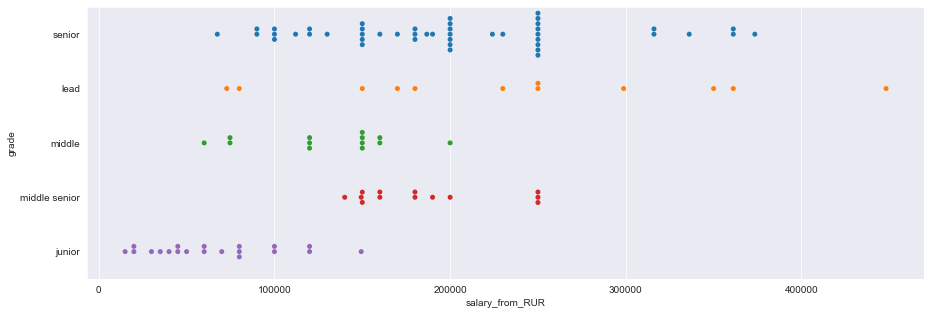

In [122]:
plt.figure(figsize=(15,5))
sns.swarmplot(x="salary_from_RUR", y="grade", data=data_graph)

In [123]:
# jun_up_threshold = data_graph[data_graph["rank"]=="middle"]["salary_from_RUR"].min()
jun_up_threshold = 100000
# sen_low_threshold = data_graph[data_graph["rank"]=="middle"]["salary_from_RUR"].max()
# sen_low_threshold = 250000
# mid_low_threshold = data_graph[(data_graph["rank"]=="junior") &
#                               (data_graph["salary_from_RUR"]<200000)]["salary_from_RUR"].max()
# mid_up_threshold = data_graph[(data_graph["rank"]=="senior") &
#                               (data_graph["salary_from_RUR"]>140000)]["salary_from_RUR"].min()

# print(f"Зарплаты junior: до {jun_up_threshold}")
# print(f"Зарплаты senior: от {sen_low_threshold}")
# print(f"Зарплаты middle: от {mid_low_threshold} до {mid_up_threshold}")

In [124]:
data_extended.loc[(data_extended["grade"].isnull()) & 
                  (data_extended['salary_from_RUR']<jun_up_threshold), 'grade'] = 'junior'
# data_extended.loc[(data_extended["rank"].isnull()) & 
#                   (data_extended['salary_from_RUR']>sen_low_threshold), 'rank'] = 'senior'
# data_extended.loc[(data_extended["rank"].isnull()) & 
#                   (data_extended['salary_from_RUR']>mid_low_threshold) &
#                   (data_extended['salary_from_RUR']<mid_up_threshold), 'rank'] = 'middle'
data_extended.groupby(['grade'])['grade'].count()

grade
junior           584
lead             347
middle           235
middle senior    112
senior           528
Name: grade, dtype: int64

In [125]:
data_graph = data_extended[(data_extended['area_name']=="Москва") &
                           ((data_extended['salary_from_RUR']!=None) | (data_extended['salary_to_RUR']!=None))
                          ][['grade', 'salary_from_RUR', 'salary_to_RUR']]

<AxesSubplot:xlabel='salary_to_RUR', ylabel='grade'>

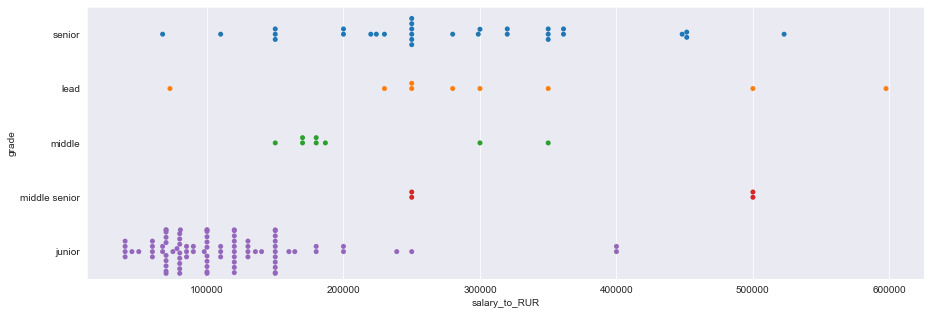

In [126]:
plt.figure(figsize=(15,5))
sns.swarmplot(x="salary_to_RUR", y="grade", data=data_graph)

In [127]:
jun_up_threshold = data_graph[data_graph["grade"]=="senior"]["salary_to_RUR"].min()
# jun_up_threshold = 150000
jun_up_threshold

67478.0

In [128]:
# sen_low_threshold = data_graph[(data_graph["rank"]=="middle") &
#                               (data_graph["salary_to_RUR"]<300000)]["salary_to_RUR"].max()
# sen_low_threshold

In [129]:
data_extended.loc[(data_extended["grade"].isnull()) & 
                  (data_extended['salary_to_RUR']<jun_up_threshold), 'rank'] = 'junior'
# data_extended.loc[(data_extended["rank"].isnull()) & 
#                   (data_extended['salary_to_RUR']>sen_low_threshold), 'rank'] = 'senior'
data_extended.loc[(data_extended['grade']!='junior') & (~data_extended['grade'].isna()), 'grade'] = 'not junior'

data_extended.groupby(['grade'])['grade'].count()

grade
junior         584
not junior    1222
Name: grade, dtype: int64

In [130]:
# def get_requirements(text, corpus, is_words=False):
#     tmp = [list(elem) for elem in text.keys()]
#     if is_words:     
#         return [key for key in tmp if key[0] in corpus]
#     else:
#         return [key for key in tmp if key in corpus]

In [131]:
# data_extended['req_words'] = data_extended['word_counts'].apply(get_requirements, corpus=corpus_words, is_words=True)
# data_extended['req_bigrams'] = data_extended['bigram_counts'].apply(get_requirements, corpus=corpus_bigrams)
# data_extended['req_trigrams'] = data_extended['trigram_counts'].apply(get_requirements, corpus=corpus_trigrams)
# data_extended['req_fourgrams'] = data_extended['fourgram_counts'].apply(get_requirements, corpus=corpus_fourgrams)

In [132]:
data_categorized = data_extended[~data_extended["grade"].isna()][['grade',
                                                                 'good_key_phrases_2grams','good_key_phrases_3grams' ,
                                                                 'good_key_phrases_4grams','good_key_phrases_5grams',
                                                                 'good_key_phrases_6grams','tech_stack',
                                                                 ]]

In [133]:
data_categorized['good_key_phrases_2grams'] = data_categorized['good_key_phrases_2grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_3grams'] = data_categorized['good_key_phrases_3grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_4grams'] = data_categorized['good_key_phrases_4grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_5grams'] = data_categorized['good_key_phrases_5grams'].apply(flatten_list_of_lists)
data_categorized['good_key_phrases_6grams'] = data_categorized['good_key_phrases_6grams'].apply(flatten_list_of_lists)
data_categorized['tech_stack'] = data_categorized['tech_stack'].apply(list_to_string)

In [134]:
data_categorized.iloc[0]['good_key_phrases_3grams'] 

'опыт работа больший работа больший объём больший объём данные python анализ данные опыт работа tableau расширить социальный пакет офис центр город'

In [135]:
# data_categorized['experience_name'] = data_categorized.experience_name.apply(preprocess_text)
# data_categorized['employment_name'] = data_categorized.employment_name.apply(preprocess_text)

In [136]:
data_categorized['text'] = data_categorized[['good_key_phrases_2grams','good_key_phrases_3grams' ,
                                                                 'good_key_phrases_4grams','good_key_phrases_5grams',
                                                                 'good_key_phrases_6grams','tech_stack',]]\
                                         .agg(' '.join, axis=1)
# data_categorized['text'] = data_categorized['desc_lemm']


In [137]:
data_categorized.iloc[0]['text'] 

'ml модель поведение пользователь гипотеза улучшение улучшение продукт анализировать дать мобильный приложение опыт работа работа больший больший объём объём данные знание python python анализ анализ данные когортный анализ знание sql проводить b b тест работа tableau оплата труд расширить социальный социальный пакет медицинский страховка английский язык частичный компенсация компенсация спорт офис центр центр город ст м опыт работа больший работа больший объём больший объём данные python анализ данные опыт работа tableau расширить социальный пакет офис центр город опыт работа больший объём работа больший объём данные опыт работа больший объём данные  v ml tableau python анализ данные'

In [138]:
data_categorized['text'] = data_categorized[['good_key_phrases_2grams','good_key_phrases_3grams','tech_stack',]]\
                                         .agg(' '.join, axis=1)

In [139]:
words_count = defaultdict(lambda: 0)

for text in data_categorized.text:
    for word in text:
        words_count[word] +=1
        
len(words_count)

69

In [140]:
top_words = 1000   # ограниичимся словарём из 1000 самых частых слов

sorted_words = sorted(words_count.items(), key=lambda w:w[1], reverse=True)
freq_words = {item[0] for item in sorted_words[:top_words]}

encoder = dict(zip(freq_words, list(range(1,len(freq_words) + 1))))

# функция-фильтр
def freq_filter(text):
    return np.array([encoder[word] for word in text if word in freq_words])

data_categorized['freq_text'] = data_categorized.text.apply(freq_filter)

In [141]:
data_categorized = data_categorized[data_categorized.freq_text.apply(len) > 1]

In [142]:
ranks = list(set(data_categorized['grade']))
ranks

['not junior', 'junior']

In [143]:
le = preprocessing.LabelEncoder()
rank_encode = le.fit_transform(ranks)
rank_encoder = dict(zip(ranks, rank_encode))
rank_encoder

{'not junior': 1, 'junior': 0}

In [144]:
data_categorized['grade'] = data_categorized['grade'].map(rank_encoder)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(data_categorized["freq_text"], 
                                                    data_categorized["grade"], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [146]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# как выглядит вектор
# X_train.iloc[25][:300]

1354 train sequences
452 test sequences


## Классификация грейда вакансий с TF

In [147]:
max_text_length = 1000         

X_train = sequence.pad_sequences(X_train, maxlen=max_text_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_text_length)

In [148]:
NEIRONS = len(ranks)
embedding_vector_length = 64    # размерность эмбендинга
top = top_words + 1             # на вход идут слова и нулевой элемент

adam = tf.keras.optimizers.Adam(
    learning_rate=0.01, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07, 
    amsgrad=False,
    name='Adam',
)

In [149]:
model = Sequential()
model.add(Embedding(top, embedding_vector_length, input_length=max_text_length))
model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))
# model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dense(NEIRONS, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [150]:

with tf.device('/CPU:0'):
    hist = model.fit(X_train, y_train, validation_split=0.15, epochs=6, batch_size=40)

Epoch 1/6
29/29 [==============================] - 6s 137ms/step - loss: 0.6376 - accuracy: 0.6236 - val_loss: 0.6209 - val_accuracy: 0.6275
Epoch 2/6
29/29 [==============================] - 4s 133ms/step - loss: 0.5903 - accuracy: 0.6774 - val_loss: 0.5979 - val_accuracy: 0.6863
Epoch 3/6
29/29 [==============================] - 4s 128ms/step - loss: 0.5680 - accuracy: 0.7014 - val_loss: 0.5893 - val_accuracy: 0.6716
Epoch 4/6
29/29 [==============================] - 3s 111ms/step - loss: 0.5753 - accuracy: 0.7083 - val_loss: 0.6017 - val_accuracy: 0.6961
Epoch 5/6
29/29 [==============================] - 4s 127ms/step - loss: 0.5476 - accuracy: 0.7388 - val_loss: 0.5975 - val_accuracy: 0.7206
Epoch 6/6
29/29 [==============================] - 4s 146ms/step - loss: 0.5787 - accuracy: 0.7077 - val_loss: 0.5730 - val_accuracy: 0.7353


In [151]:
with tf.device('/CPU:0'):
    scores = model.evaluate(X_test, y_test, verbose=0)
    prob = model.predict_proba(X_test)
print('Accuracy: %.4f'%(scores[1]))

Accuracy: 0.7058


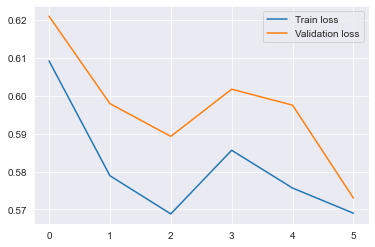

In [152]:

# когда начали переобучаться
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

## Классификация грейда вакансий с NaiveBayes

In [153]:

vectorizer = TfidfVectorizer(stop_words=stopwords)

In [154]:
data_categorized['text'] = data_categorized[['good_key_phrases_2grams','tech_stack',]]\
                                         .agg(' '.join, axis=1)
vectors = vectorizer.fit_transform(data_categorized["text"])

In [155]:
X_train, X_test, y_train, y_test = train_test_split(vectors, 
                                                    data_categorized["grade"], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [156]:
def fit_NBclassifier(trainset, trainlabel):
    nbclassifier = MultinomialNB()
    nbclassifier.fit(trainset, trainlabel)
    
    return nbclassifier

In [157]:
NB_clf = fit_NBclassifier(X_train, y_train)

In [158]:
label_predicted = NB_clf.predict(X_test)

In [159]:
accuracy = accuracy_score(y_test, label_predicted) # accuracy rate of the classifier
accuracy

0.7651933701657458

In [160]:
# sents = pd.Series([col for col in data_extended.desc_sentences for col in col]).drop_duplicates()

In [161]:
# sents.to_csv('all_sentences.csv', encoding="utf-8-sig")

In [162]:
# sents.to_excel('all_sentences.xlsx', encoding="utf-8-sig")